**Problema de negócio:**
A empresa CCD é uma empresa que oferece o SERVIÇO de DIAGNÓSTICO DE DOENÇAS CARDIOVASCULATES EM ESTÁGIOS INICIAIS.
O custo de cada diagnóstico é de R$ 1000,00. 
O preço que o cliente paga por cada diagnóstico paga é de 500 reais a cada 5% de acurácia acima de 50%.
Hoje, a precisão dos diagnósticos varia de 55 a 65%, o que faz com que a empresa hora tenha um lucro de 500 reais, hora tenha um prejuízo, hora se pague.
O problema é a IMPREVISIBILIDADE DO FLUXO DE CAIXA. Portanto, precisamos criar um modelo que tenha a mesma acurácia em todas as previsões, respondendo as seguitnes perguntas: 

    1. Qual a Acurácia e a Precisão da ferramenta?
    2. Quanto lucro a Cardio Catch Diseases passará a ter com a nova ferramenta?
    3. Qual a Confiabilidade do resultado dados pela nova ferramenta?


Planejamento da solução: 

1. Encontrar um dataset com features e ocorrência de cardio catch disease
2. Limpar, explorar e fazer as features engineerings necessárias -> pesquisar sobre suas influências nas doenças de coração
3. Criar hipóteses e retirar insights
4. Selecionar as features mais relevantes
5. Aplicar modelos de machine learning
6. Fazer as avaliações dos modelos e escolher o que irá para produção


# Imports

In [183]:
from dython import nominal as dy #is a package with some helper functions such as cramer-v, theils-u 
import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
import random
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec


from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.svm             import SVC
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.metrics         import classification_report
from sklearn.metrics         import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model    import LogisticRegressionCV
from sklearn.model_selection import KFold, cross_validate
from boruta                  import BorutaPy

from scipy                 import stats  as ss


## Helper functions

In [167]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()



#feature engineering functions

# people with blood pressure 140:90 most of the time are considered hypertensive
def hypertension(high, low):
    if high >= 140 and (low >= 90):
        hypertense = 1
        
    else: 
         
        hypertense = 0
    return hypertense


def bmi(height, weight):
    bmi = bmi = weight/((height/100) ** 2)
    
    return bmi

# accordind to the bmi people can have normal (0), overweighted (1), obese level 1 (2), obese level (2)
def obesity(bmi):
    
    if bmi >= 25:
        if bmi >= 30:
            if bmi >= 40:
                obesity = 3
            else:
                obesity = 2
        else:
            obesity = 1
    else: 
        obesity = 0
    
    return obesity


# list of outliers in a data considering gaussian/boxplot
def detect_outlier(data):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(data), [25, 75])

    # compute IQR
    iqr = q3 - q1

    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    outliers = [x for x in data if x <= lower_bound or x >= upper_bound]

    return outliers


# upper and lower bounds 
def bounds(data):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(data), [25, 75])

    # compute IQR
    iqr = q3 - q1

    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    return lower_bound, upper_bound
        
# stacked barplots for EDA
def stacked_barplot(data, feature):
    

    # raw value to percentage
    total = data.groupby(feature)['id'].count().reset_index()
    sick = data[data['cardio'] == 1].groupby(feature)['id'].count().reset_index()
    sick['id'] = [ i / j * 100 for i,j in zip(sick['id'], total['id'])]
    total['id'] = [i / j * 100 for i,j in zip(total['id'], total['id'] ) ]

    # bar chart 1  = top bars( group of healthy)
    bar1 = sns.barplot(x=feature, y='id', data = total, color='darkblue')

    # bar chart 2 = bottom bars (group of sick)
    bar2 = sns.barplot(x=feature, y='id', data =  sick, color = 'lightblue')

    # legend
    top_bar = mpatches.Patch(color='darkblue', label='CVD = No')
    bottom_bar = mpatches.Patch(color='lightblue', label='CVD = Yes')
    plt.legend(handles=[top_bar, bottom_bar])

    # show the graph
    graph = plt.show()
    
    return graph


def metrics(y_test, yhat, model):
    performance_df = pd.DataFrame(classification_report(y_test, yhat, output_dict=True))

    accuracy = performance_df.iloc[0,2]
    precision_0 = performance_df.iloc[0,0]
    recall_0 = performance_df.iloc[1,0]
    f1_score_0 = performance_df.iloc[2,0]

    precision_1 = performance_df.iloc[0,1]
    recall_1 = performance_df.iloc[1,1]
    f1_score_1 = performance_df.iloc[2,1]

    performance_list = [model, accuracy, precision_1, recall_1, f1_score_1, precision_0, recall_0, f1_score_0]
    
    
    performance_model = pd.DataFrame(performance_list).T 
    performance_model.columns=['model', 'accuracy', 'precision_1', 'recall_1', 'f1_score_1',  'precision_0', 'recall_0', 'f1_score_0']
    performance_model
    
    
    print(performance_model)
    ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, yhat)).plot()
    return performance_model

def cross_validation(model, model_name, X, y):
    scores = cross_validate(model, X, y, scoring=['accuracy',
                                  'precision',
                                  'recall', 
                                  'f1'], return_train_score=False)
    scores_mean = mean(pd.DataFrame(scores)).tolist()[2:]
    scores_std = std(pd.DataFrame(scores)).tolist()[2:]
    scores_final = []
    
    for i in range(len(scores_mean)):
        scores_final.append(str(round(scores_mean[i], 4)) + ' +/- ' + str(round(scores_std[i], 4)))

        
    performance_model = [model_name] + scores_final
    performance_model = pd.DataFrame(performance_model).T
    performance_model.columns = ['model', 'accuracy', 'precision_1', 'recall_1', 'f1_score_1']
    
    return performance_model



Populating the interactive namespace from numpy and matplotlib


# Data collection

In [8]:
df_raw = pd.read_csv('/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/data/cardio_train.csv', sep=';')

In [9]:
df_raw.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [10]:
# separate data to test the solution after deploy

x = df_raw.drop(columns='cardio')
y = df_raw.cardio

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)

train = pd.concat([x_train, y_train], axis = 1).reset_index(drop=True)
test = pd.concat([x_test, y_test], axis = 1).reset_index(drop=True)

# Data descriptive

Features:

Age | Objective Feature | age | int (days)

Height | Objective Feature | height | int (cm) |

Weight | Objective Feature | weight | float (kg) |

Gender | Objective Feature | gender | categorical code |

Systolic blood pressure | Examination Feature | ap_hi | int |

Diastolic blood pressure | Examination Feature | ap_lo | int |

Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |

Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |

Smoking | Subjective Feature | smoke | binary |

Alcohol intake | Subjective Feature | alco | binary |

Physical activity | Subjective Feature | active | binary |

Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

In [11]:
df1 = train.copy()

In [12]:
df1.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [13]:
# trasformation of age from days to years
df1['age_years'] = df1['age'].apply(lambda x: x/365).astype('int64')

In [14]:
df1.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
0,67617,21876,1,154,80.0,130,90,2,1,0,0,1,1,59
1,96320,16717,2,162,70.0,140,90,1,1,0,0,0,1,45
2,17571,21128,2,174,92.0,150,100,1,1,0,0,1,1,57
3,46492,23366,2,173,76.0,120,82,1,1,0,0,1,1,64
4,945,20281,1,160,60.0,120,80,1,1,0,0,1,0,55


## Data dimensions

In [15]:
print('Number_of_rows:' , format(df1.shape[0]))
print('Number_of_columns:' , format(df1.shape[1]))

Number_of_rows: 56000
Number_of_columns: 14


## Data types

In [16]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
age_years        int64
dtype: object

In [17]:
#categorical: gender, cholesterol, gluc, smoke, alco, active, cardio

## Data missing

In [18]:
df1.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
age_years      0
dtype: int64

In [19]:
#check if each data refers to a different patient or to same patients in different times
len(df1['id'].unique())

56000

## Descriptive statistical

In [20]:
num_attributes = df1[['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']]
cat_attributes = df1[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']]

### Numerical attributes

In [21]:
# central tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion: std, min, max, skew, kurtosis, range
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concatenate all
stats_summary = pd.concat( [d2, d3, ct1, ct2, d4, d5, d6] ).T.reset_index()
stats_summary.columns = ['attribute', 'min', 'max', 'mean', 'median', 'range', 'skew', 'kurtosis']

In [22]:
stats_summary

,attribute,min,max,mean,median,range,skew,kurtosis
0,age_years,29.0,64.0,52.830643,53.0,35.0,-0.303980,-0.818935
1,height,55.0,250.0,164.348125,165.0,195.0,-0.594831,7.616794
2,weight,22.0,200.0,74.188586,72.0,178.0,1.015661,2.630229
3,ap_hi,-140.0,14020.0,128.737893,120.0,14160.0,85.641414,7642.334178
4,ap_lo,0.0,11000.0,97.025536,80.0,11000.0,31.969044,1369.195570


With the results above, we must check possible outliers, such as heigh, cause minimum is 55 cm, weight (10 kg, since the minimum age of this dataset is 29), and both values from blood pressure less than 0 and too high.


Some information about:

1. Height: The shortest person in the world is 54,6 cm high. But this is actually the approximately height of a newborn.  The tallest is 251 cm high. 
2. Weight:A person can go higher than 200 kg. But a 1 year old would have 10 kg or more of weight.
3. Blood pressure: First of all, blood pressure would never be negative. In second place, they would never go as high as their maximum, so they're probably outliers

<AxesSubplot:xlabel='ap_hi', ylabel='ap_lo'>

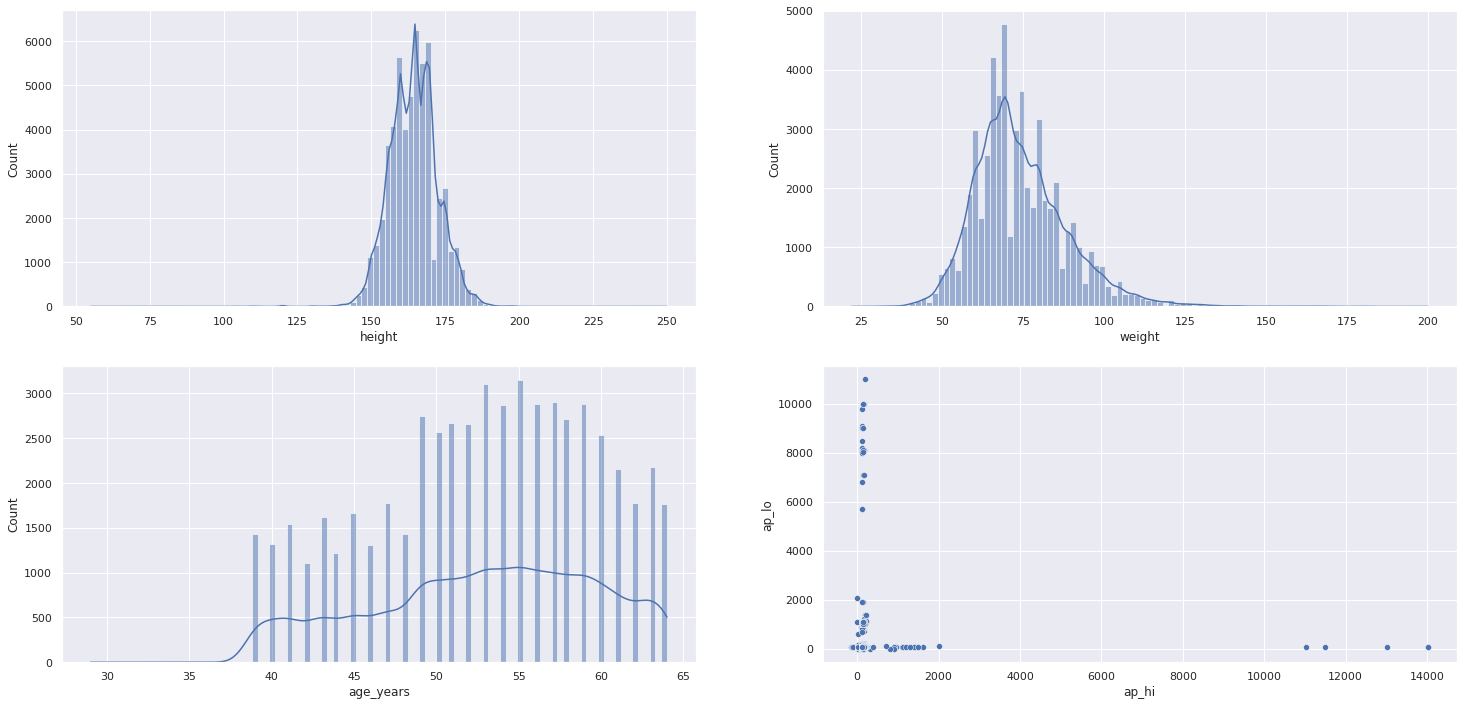

In [23]:
plt.subplot(2,2,1)
sns.histplot(x='height', data=df1, kde=True, bins = 100)

plt.subplot(2,2,2)
sns.histplot(x='weight', data=df1, kde=True, bins = 100)

plt.subplot(2,2,3)
sns.histplot(x='age_years', data=df1, kde = True,  bins = 100)

plt.subplot(2,2,4)
sns.scatterplot(x='ap_hi', y= 'ap_lo', data=df1)

<AxesSubplot:ylabel='ap_lo'>

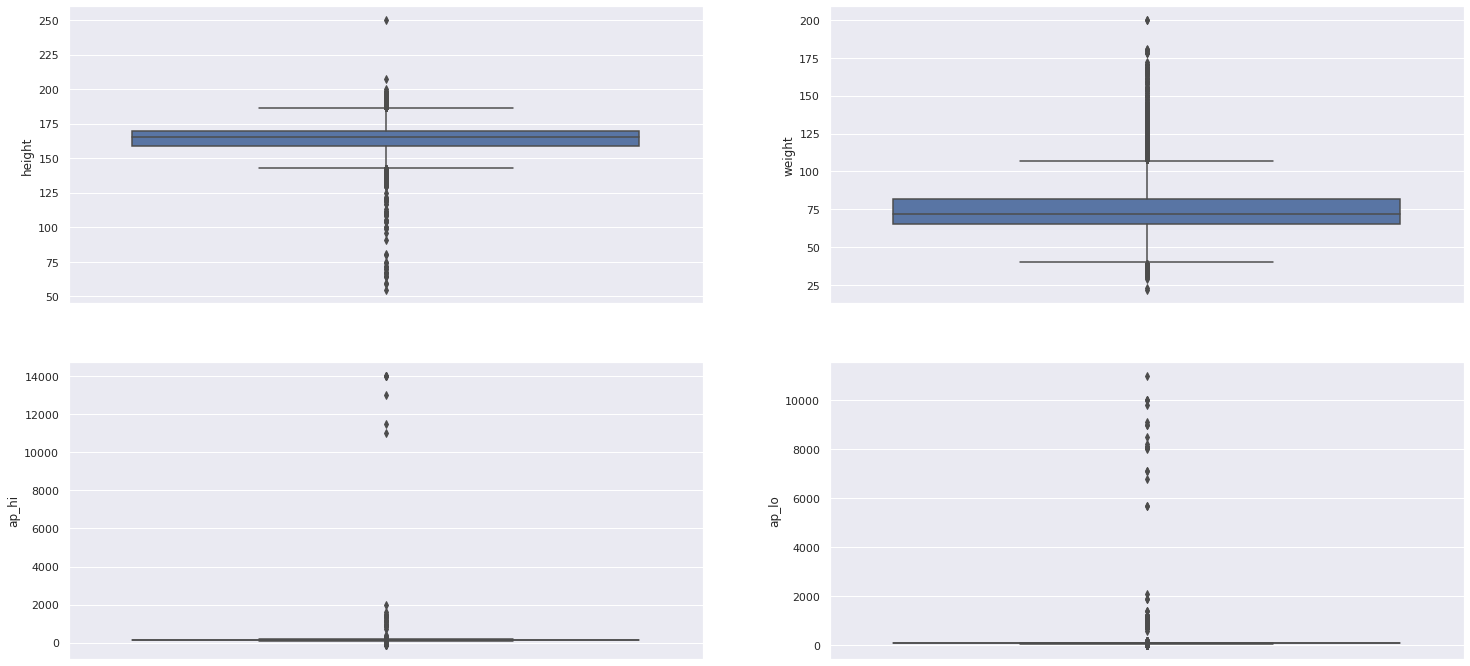

In [24]:
plt.subplot(2,2,1)
sns.boxplot(y='height', data=df1)

plt.subplot(2,2,2)
sns.boxplot(y='weight', data=df1)

plt.subplot(2,2,3)
sns.boxplot(y='ap_hi', data=df1)

plt.subplot(2,2,4)
sns.boxplot(y='ap_lo', data=df1)

#### Dealing with outliers

First, I'm going to check how many outliers I have, according to each feature above using the gaussian/boxplot approach. Then, I'm going to decide the best treatment for each one

In [25]:
#height
data = df1['height']
outliers = len(detect_outlier(data))
proportion = round((outliers/df1.shape[0]) * 100, 2)
lower_bound_height = bounds(data)[0]
upper_bound_height = bounds(data)[1]
print('There are {} outliers in height, which represents {}% of the dataset'.format(outliers, proportion))
print('The lower bound is {} cm and the upper bound is {} cm'. format(lower_bound_height, upper_bound_height))
print('')

#weight
data = df1['weight']
outliers = len(detect_outlier(data))
proportion = round((outliers/df1.shape[0]) * 100, 2)
lower_bound_weight = bounds(data)[0]
upper_bound_weight = bounds(data)[1]
print('There are {} outliers in weight, which represents {}% of the dataset'.format(outliers, proportion))
print('The lower bound is {} kg and the upper bound is {} kg'. format(lower_bound_weight, upper_bound_weight))
print('')

#ap_hi
data = df1['ap_hi']
outliers = len(detect_outlier(data))
proportion = round((outliers/df1.shape[0]) * 100, 2)
lower_bound_hi = bounds(data)[0]
upper_bound_hi = bounds(data)[1]
print('There are {} outliers in systolic blood pressure, which represents {}% of the dataset'.format(outliers, proportion))
print('The lower bound is {}  and the upper bound is {} '. format(lower_bound_hi, upper_bound_hi))
print('')

#ap_lo
data = df1['ap_lo']
outliers = len(detect_outlier(data))
proportion = round((outliers/df1.shape[0]) * 100, 2)
lower_bound_lo = bounds(data)[0]
upper_bound_lo = bounds(data)[1]
print('There are {} outliers in diastolic blood pressure, which represents {}% of the dataset'.format(outliers, proportion))
print('The lower bound is {}  and the upper bound is {} '. format(lower_bound_lo, upper_bound_lo))
print('')

There are 401 outliers in height, which represents 0.72% of the dataset
The lower bound is 142.5 cm and the upper bound is 186.5 cm

There are 1429 outliers in weight, which represents 2.55% of the dataset
The lower bound is 39.5 kg and the upper bound is 107.5 kg

There are 2522 outliers in systolic blood pressure, which represents 4.5% of the dataset
The lower bound is 90.0  and the upper bound is 170.0 

There are 3799 outliers in diastolic blood pressure, which represents 6.78% of the dataset
The lower bound is 65.0  and the upper bound is 105.0 



For now, I'm going to drop all outliers to avoid any bias trying to treat and replace the data. Later on, I might try to treat each one of these features and tests what makes more sense based on researchs and studies


In [26]:
#height
df1 = df1[(df1['height'] >= lower_bound_height) & (df1['height'] <= upper_bound_height) ]

# weight 
df1 = df1[(df1['weight'] >= lower_bound_weight) & (df1['weight'] <= upper_bound_weight) ]

# ap_hi
df1 = df1[(df1['ap_hi'] >= lower_bound_hi) & (df1['ap_hi'] <= upper_bound_hi) ]

# ap_lo
df1 = df1[(df1['ap_lo'] >= lower_bound_lo) & (df1['ap_lo'] <= upper_bound_lo) ]

<AxesSubplot:xlabel='ap_lo', ylabel='Count'>

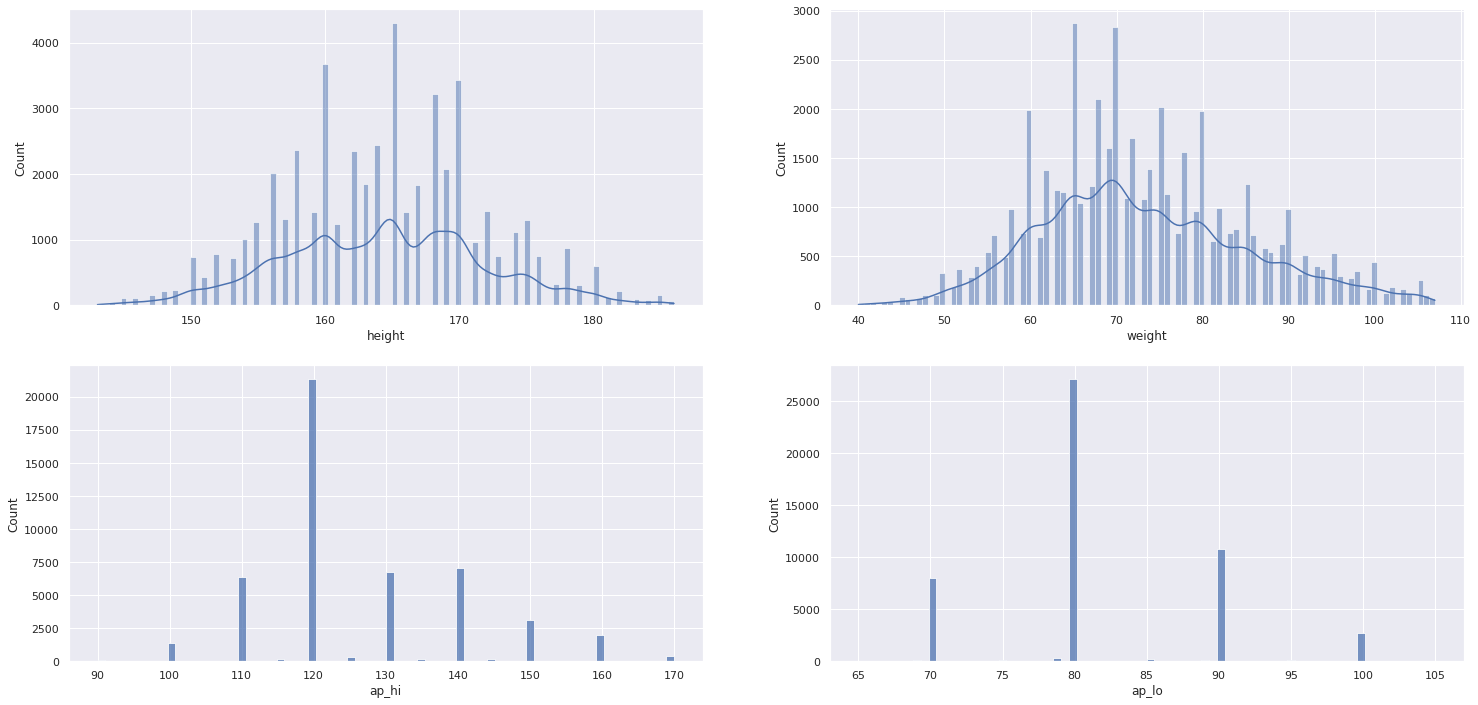

In [27]:
plt.subplot(2,2,1)
sns.histplot(x='height', data=df1, kde=True, bins = 100)

plt.subplot(2,2,2)
sns.histplot(x='weight', data=df1, kde=True, bins = 100)

plt.subplot(2,2,3)
sns.histplot(x= 'ap_hi', data=df1)

plt.subplot(2,2,4)
sns.histplot(x= 'ap_lo', data=df1)

<AxesSubplot:ylabel='ap_lo'>

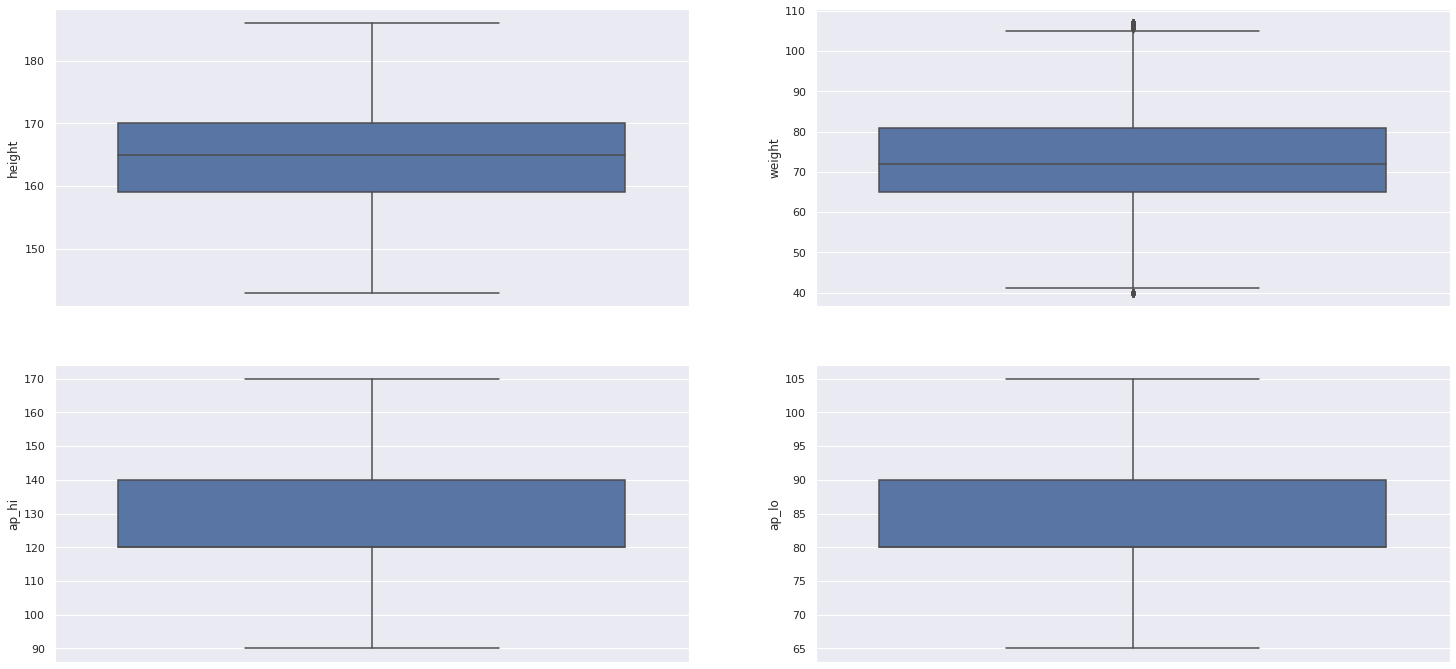

In [28]:
plt.subplot(2,2,1)
sns.boxplot( y='height', data=df1)

plt.subplot(2,2,2)
sns.boxplot(y='weight', data=df1)

plt.subplot(2,2,3)
sns.boxplot(y='ap_hi', data=df1)

plt.subplot(2,2,4)
sns.boxplot(y='ap_lo', data=df1)

### Categorical attributes

In [29]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender         2
cholesterol    3
gluc           3
smoke          2
alco           2
active         2
cardio         2
dtype: int64

<AxesSubplot:xlabel='cardio', ylabel='count'>

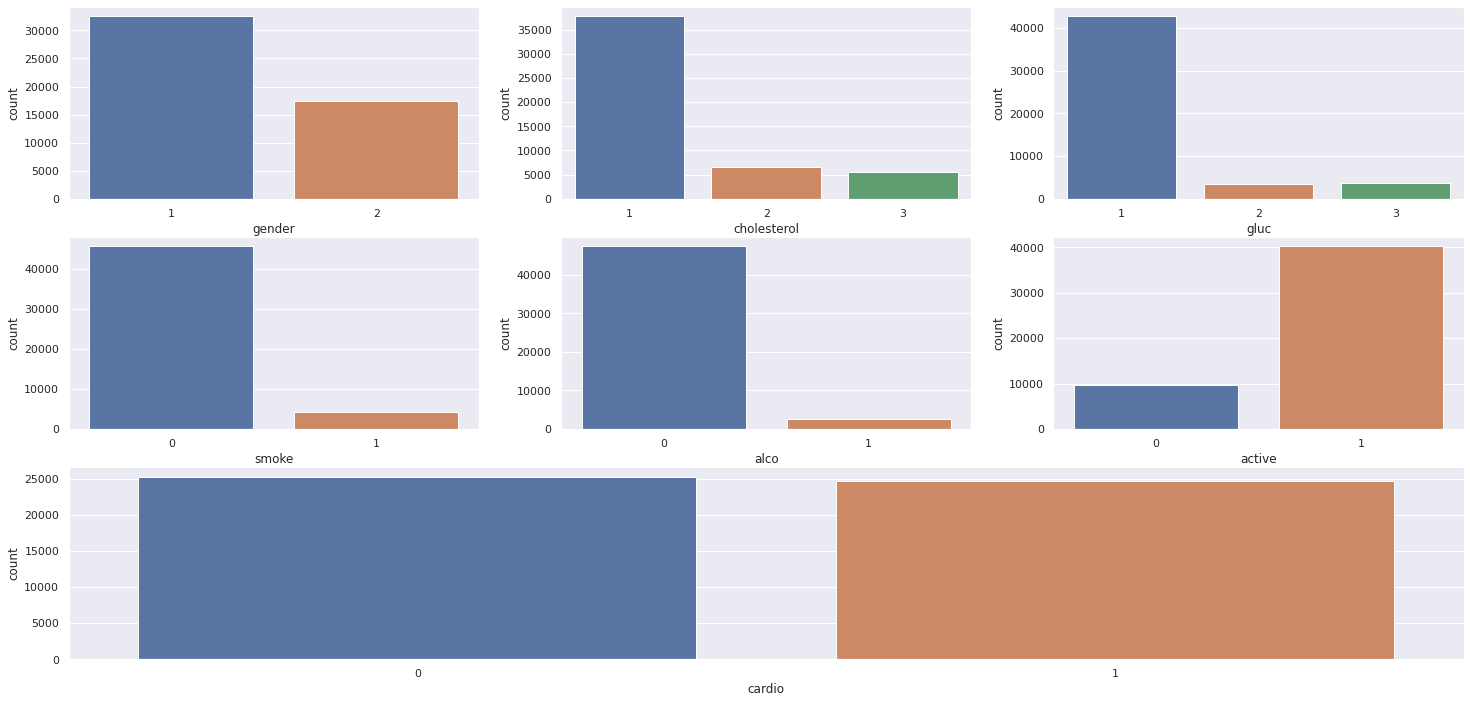

In [30]:
plt.subplot(3, 3, 1)
sns.countplot(x='gender', data=df1)

plt.subplot(3, 3, 2)
sns.countplot(x='cholesterol', data=df1)


plt.subplot(3, 3, 3)
sns.countplot(x='gluc', data=df1)

plt.subplot(3, 3, 4)
sns.countplot(x='smoke', data=df1)

plt.subplot(3, 3, 5)
sns.countplot(x='alco', data=df1)


plt.subplot(3, 3, 6)
sns.countplot(x='active', data=df1)

plt.subplot(3, 3, (7,9))
sns.countplot(x='cardio', data=df1)

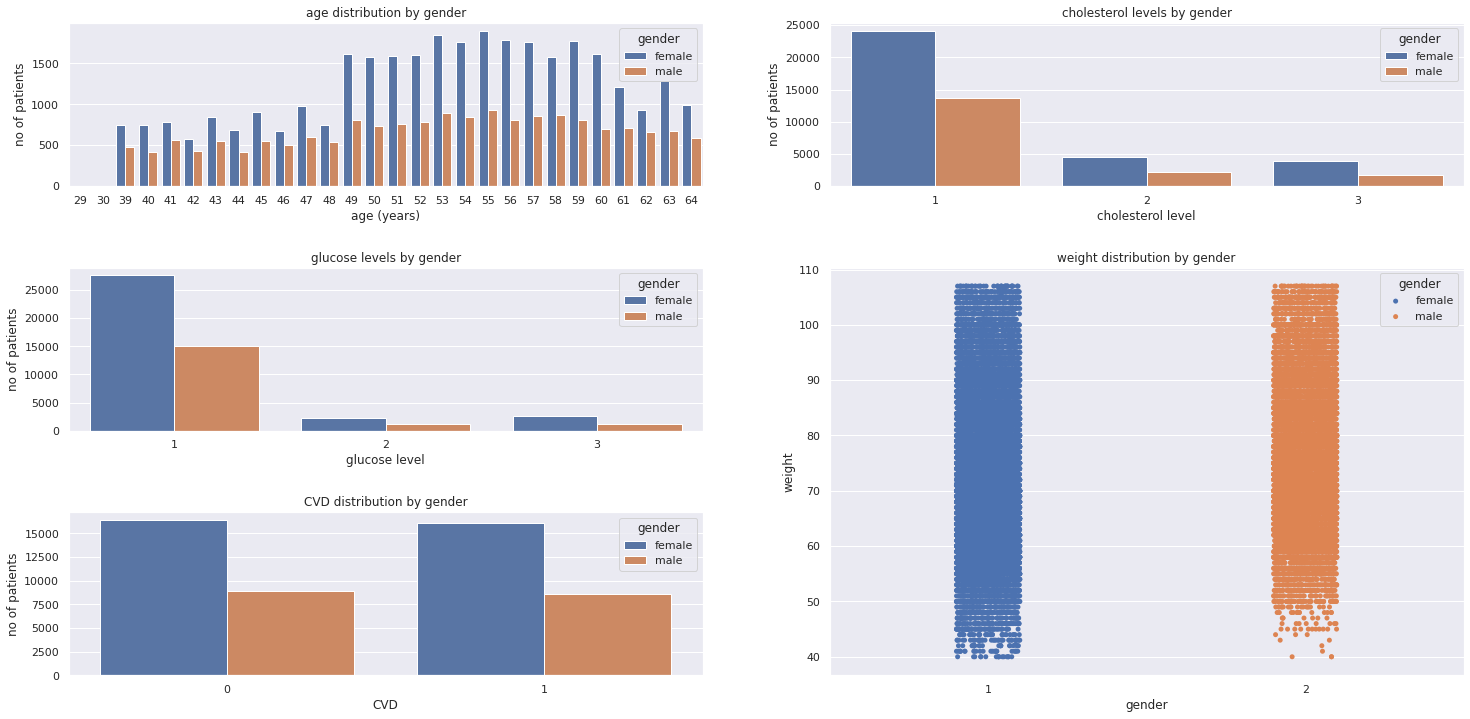

In [31]:
grid = gridspec.GridSpec(3, 2)

plt.subplot(grid[0,0])
plot = sns.countplot(x= 'age_years', hue='gender', data = df1)
plot.set(title = 'age distribution by gender', xlabel = 'age (years)', ylabel = 'no of patients')
plt.legend(title = 'gender', labels = ['female', 'male'])

plt.subplot(grid[0,1])
plot = sns.countplot(x = 'cholesterol', hue='gender', data = df1)
plot.set(title = 'cholesterol levels by gender', xlabel = 'cholesterol level', ylabel = 'no of patients')
plt.legend(title = 'gender', labels = ['female', 'male'])


plt.subplot(grid[1,0])
plot = sns.countplot(x = 'gluc', hue='gender', data = df1)
plot.set(title = 'glucose levels by gender', xlabel = 'glucose level', ylabel = 'no of patients')
plt.legend(title = 'gender', labels = ['female', 'male'])
plt.subplots_adjust(hspace = 0.5)

plt.subplot(grid[1:,-1])
plot = sns.stripplot(x = 'gender', y='weight', data = df1)
plot.set(title = 'weight distribution by gender', xlabel = 'gender', ylabel = 'weight')
plt.legend(title = 'gender', labels = ['female', 'male'])

plt.subplot(grid[2,0])
plot = sns.countplot(x='cardio', hue = 'gender', data = df1)
plot.set(title = 'CVD distribution by gender', xlabel = 'CVD', ylabel = 'no of patients')
plt.legend(title = 'gender', labels = ['female', 'male'])





Within the above results we could clearly see that our dataset is balanced between those who have cardio disease and thos who don't. It is possible to see that the variable's distribution by gender follows about the same proportion that the entire sample, since there are more women in this dataset

# Data cleaning

In [32]:
#df1['age'] = df1['age'].astype('int64')

# Feature engineering

In [33]:
df2 = df1.copy()

## Mindmap of hypothesis

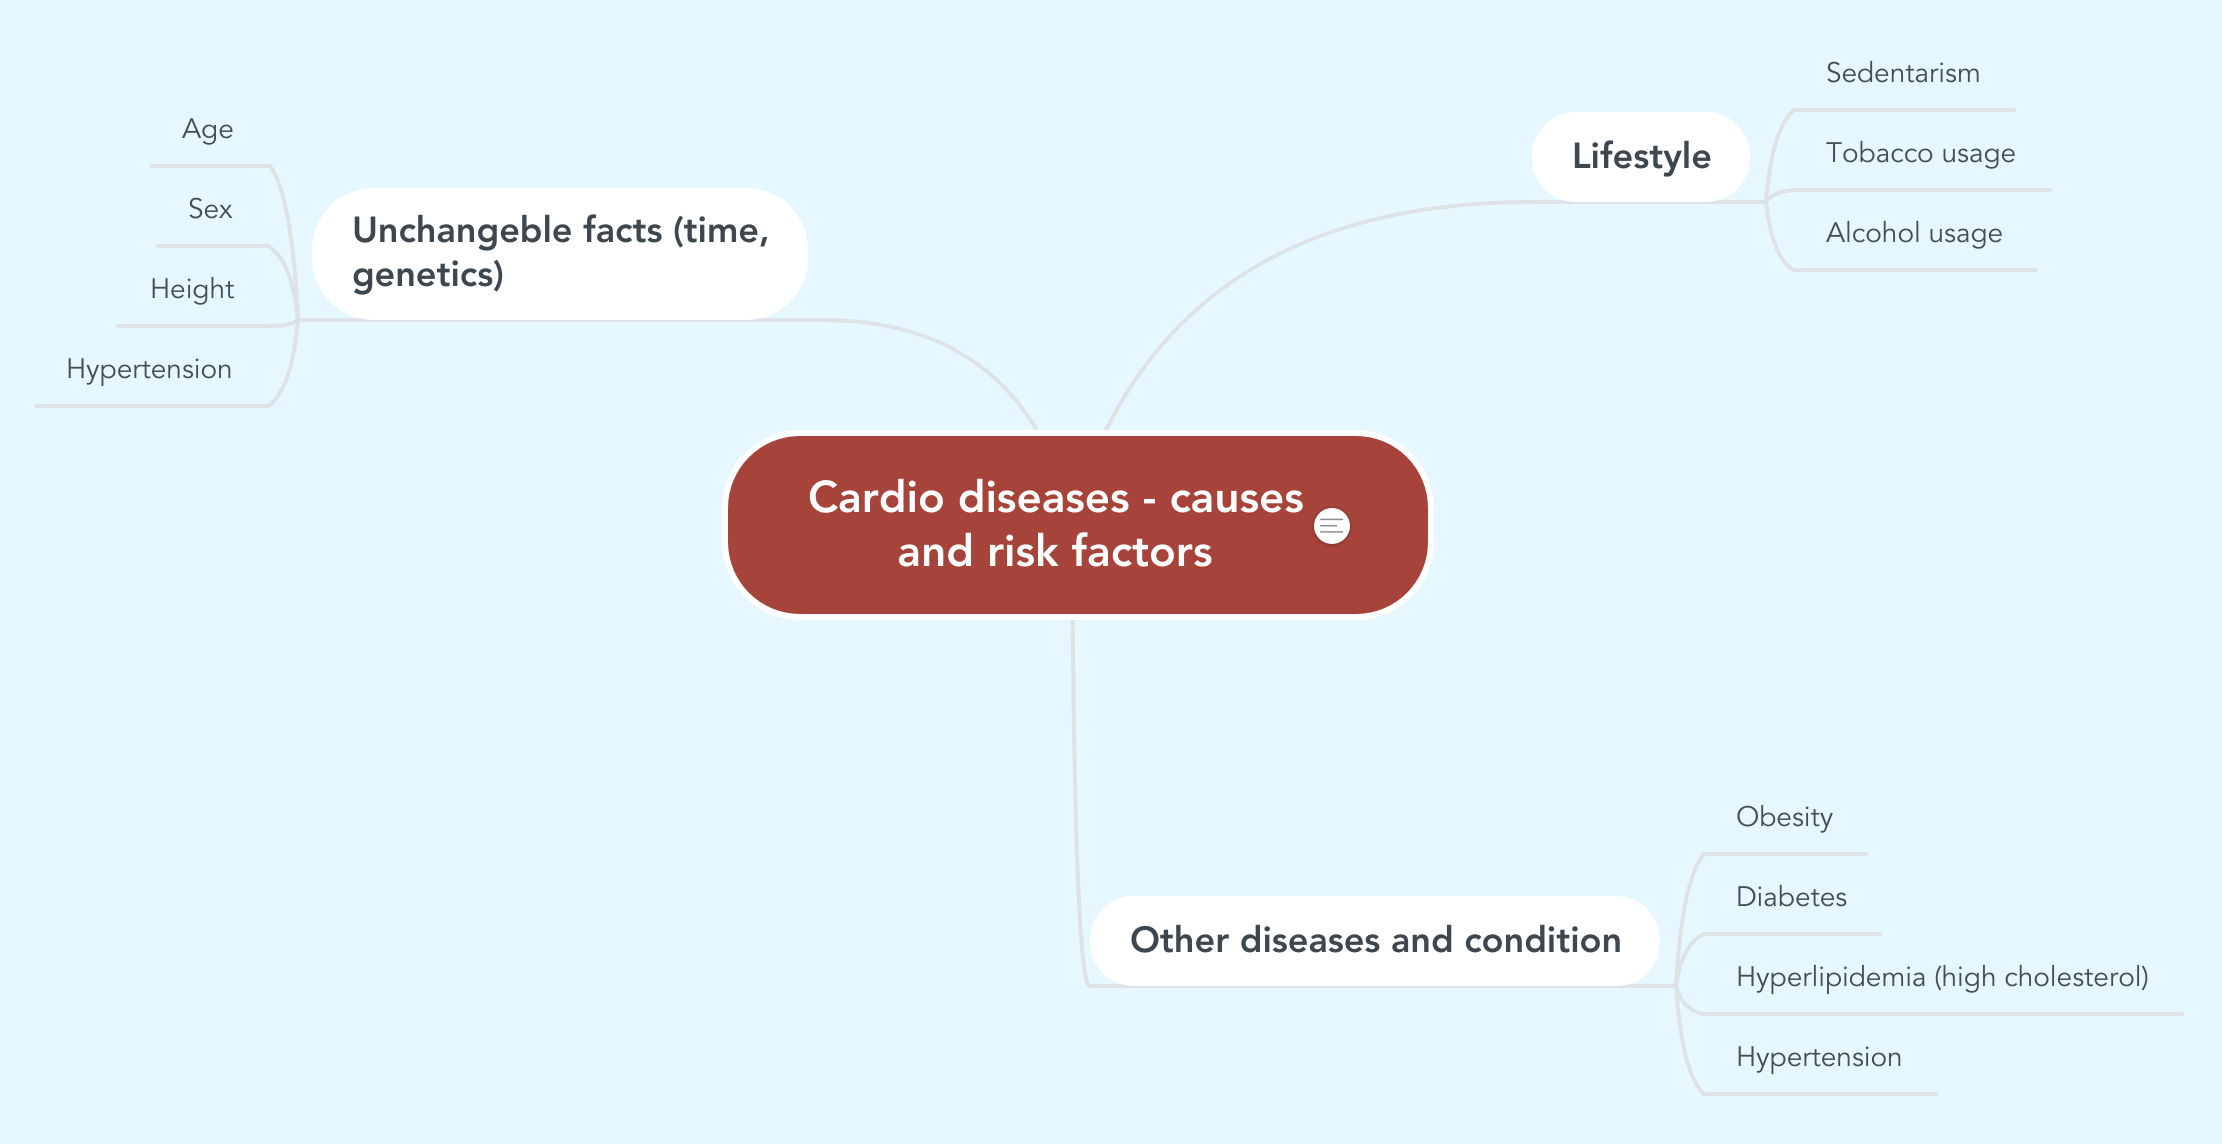

In [34]:
Image('/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/data/pa01_mindmap.png')

## Hypothesis

**H1.** People who are 50+ are more likely to have a CVD (https://www.nhs.uk/conditions/cardiovascular-disease/)<br>
**H2.** Men under 50+ are more likely to have a CVD (https://www.nhs.uk/conditions/cardiovascular-disease/)<br>
**H3.** Short people are more likely to have a CVD (https://www.escardio.org/The-ESC/Press-Office/Press-releases/Short-people-are-more-likely-to-develop-heart-disease-than-tall-people#:~:text=The%20systematic%20review%20and%20meta,it%20than%20were%20tall%20people.)<br>
**H4.** Hypertensive are more likely to have a CVD( https://www.ahajournals.org/doi/full/10.1161/HYPERTENSIONAHA.119.14240 ) <br>
**H5.** Diabetics are more likely to have a CVD (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4600176/) <br>
**H6.** People who have high levels of cholesterol are more likely to have CVD <br>
**H7.** Obese people are more likely to have a CVD <br>
**H8.** Sendentary people are more likely to have CVD <br>
**H9.** Smokers are more likely to have a CVD <br>
**H10.** People who drinks alcohol are more likely to develop CVD <br>

## Feature engineering

In [35]:
# hypertension
df2['hypertension'] = df2.apply(lambda x: hypertension(x['ap_hi'], x['ap_lo']), axis=1)


# obesity
df2['bmi'] = df2.apply(lambda x: bmi(x['height'], x['weight']), axis=1)
df2['obesity'] = df2.apply(lambda x: obesity(x['bmi']), axis=1)

#grouping by age
#df2['age_group'] = df2['age_years'].apply(lambda x: '50+' if x >= 50 else '49-')


# creating a  height classification 
#avg_h = df2['height'].mean()
#max_h = df2['height'].max()
#min_h = df2['height'].min()
#std_h = df2['height'].std()
#df2['height_class'] = df2['height'].apply(lambda x: 'tall' if (x >= avg_h + std_h ) else 'short' if (x <= avg_h - std_h) else 'regular')


In [36]:
df2.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,hypertension,bmi,obesity
0,67617,21876,1,154,80.0,130,90,2,1,0,0,1,1,59,0,33.732501,2
1,96320,16717,2,162,70.0,140,90,1,1,0,0,0,1,45,1,26.672763,1
2,17571,21128,2,174,92.0,150,100,1,1,0,0,1,1,57,1,30.387105,2
3,46492,23366,2,173,76.0,120,82,1,1,0,0,1,1,64,0,25.393431,1
4,945,20281,1,160,60.0,120,80,1,1,0,0,1,0,55,0,23.437500,0


# Exploratory Data Analysis - EDA

## Univariate analysis

In [37]:
df3 = df2.copy()
num_attributes = df3[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'age_years', 'bmi']]


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'weight'}>],
       [<AxesSubplot:title={'center':'ap_hi'}>,
        <AxesSubplot:title={'center':'ap_lo'}>,
        <AxesSubplot:title={'center':'age_years'}>],
       [<AxesSubplot:title={'center':'bmi'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

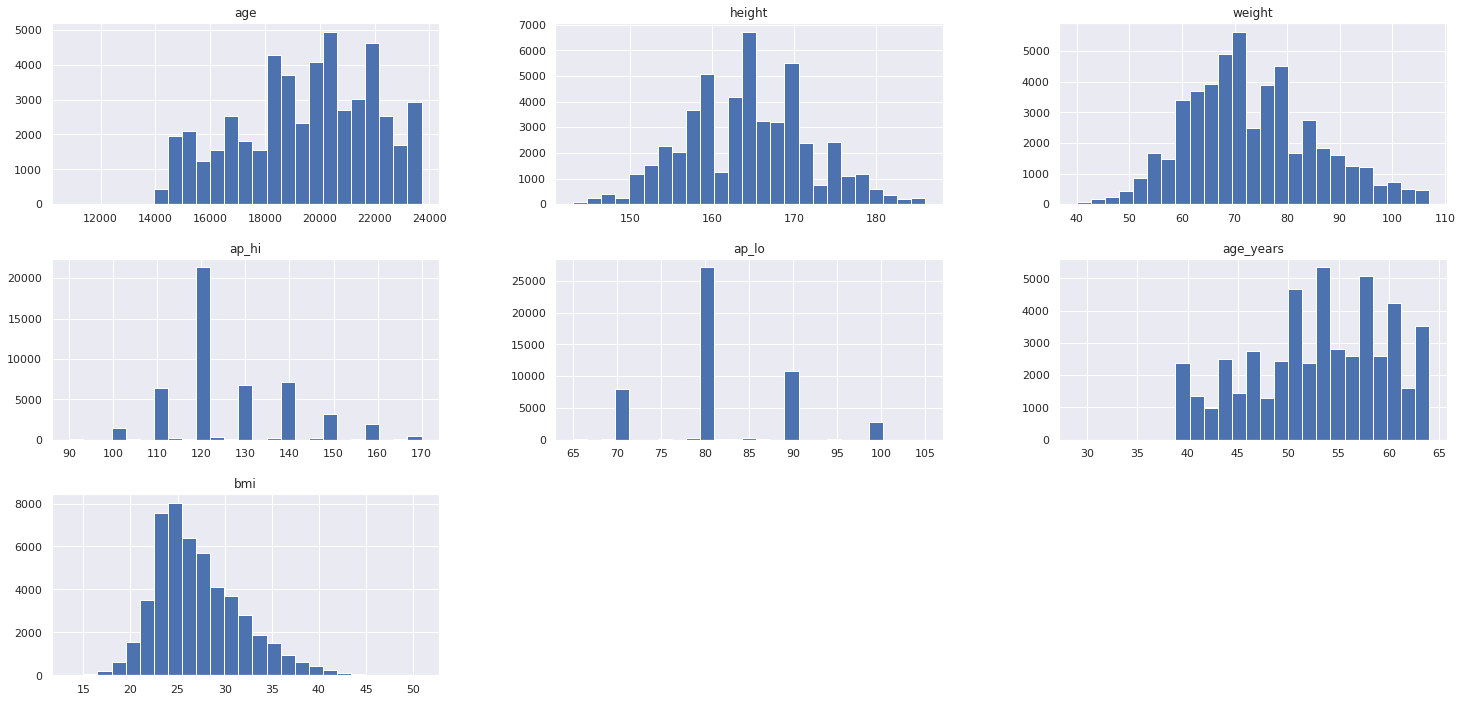

In [38]:
num_attributes.hist( bins=25 )

## Bivariate analysis

### H1. People who are 50+ should be more likely to have a CVD 
**FALSE** People who are 55+ are more likely to have a CVD

<AxesSubplot:xlabel='age_years', ylabel='count'>

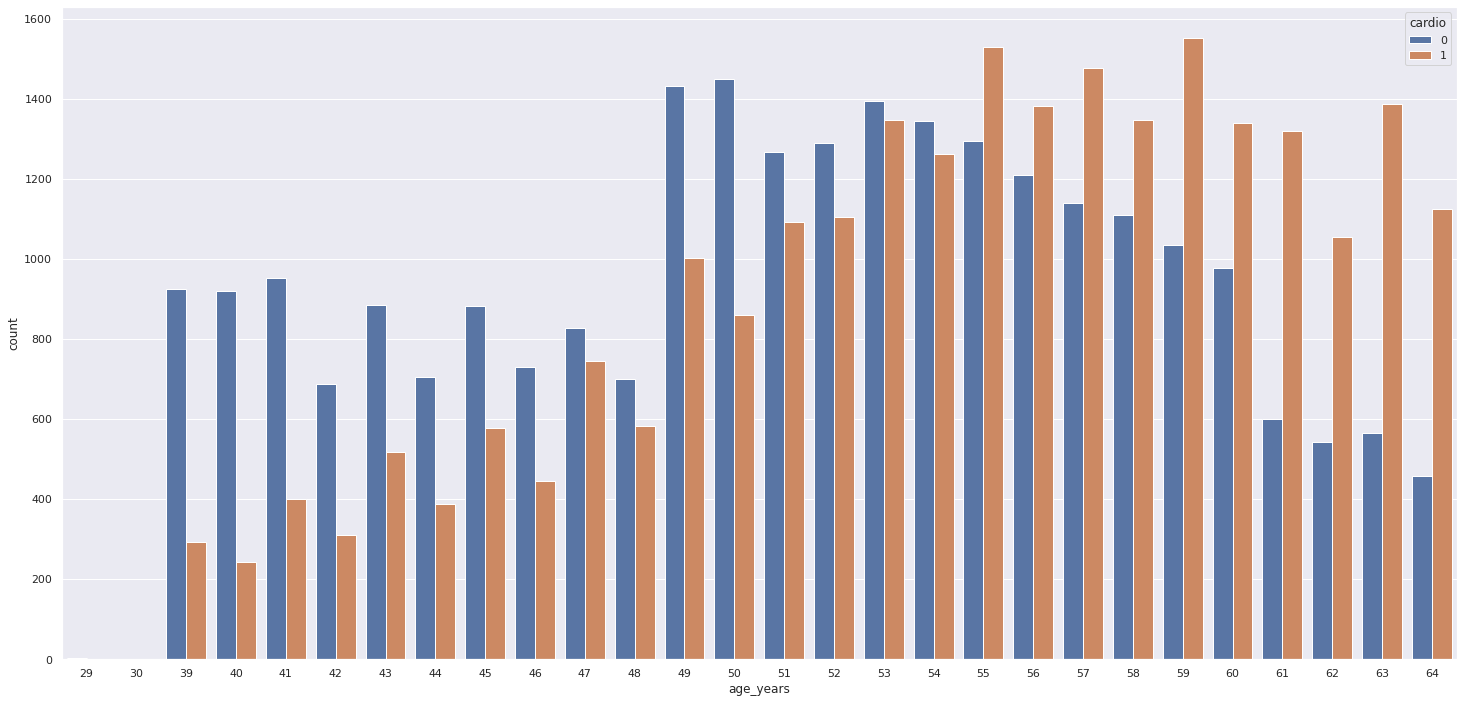

In [39]:
#plt.subplot(2,1,1)
#stacked_barplot(df3, 'age_group')

#plt.subplot(2,1,2)
sns.countplot(x='age_years', hue = 'cardio', data = df3)

### H2.  Men under 50+ should be more likely to have a CVD than woman
**FALSE** Men and women under 50 have about the same likelihood to have a CVD

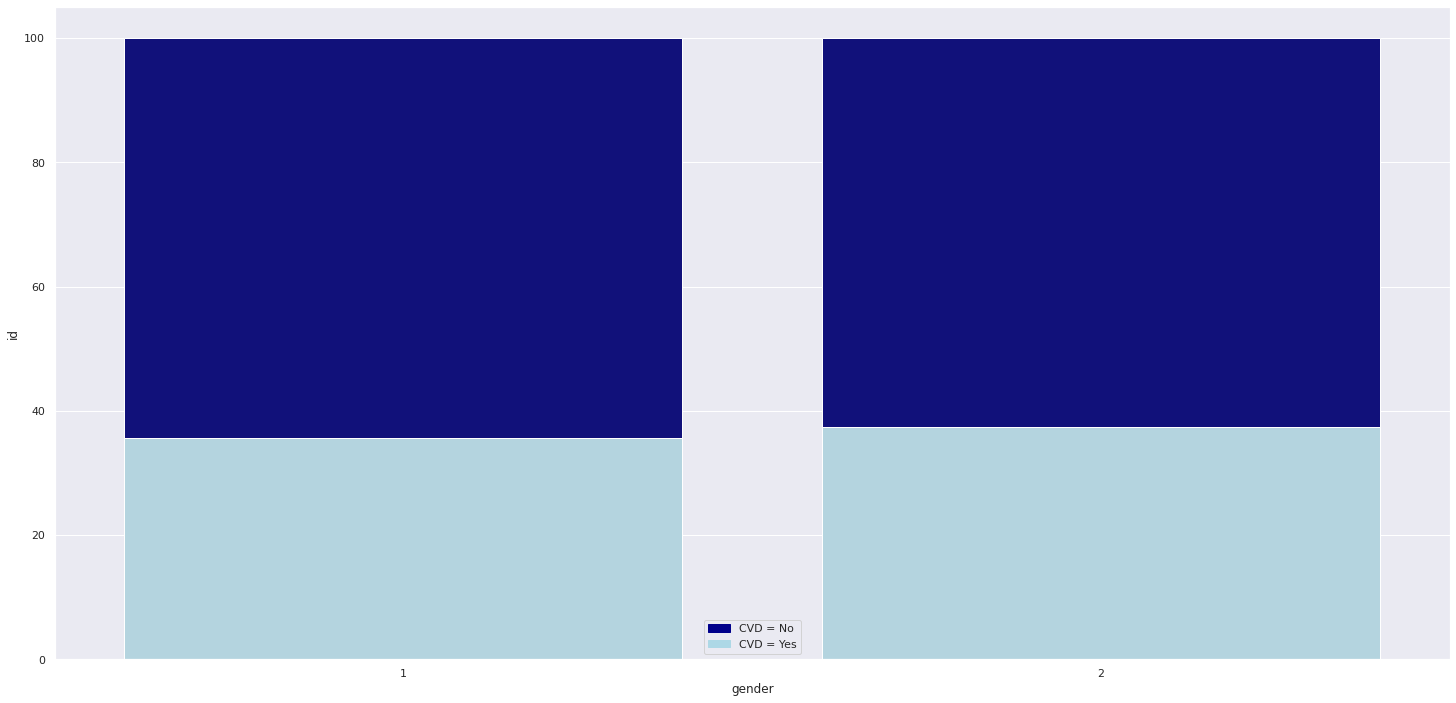

37.46% of the men and 35.67% of the woman under 50 has a CVD


In [40]:
aux = df3[df3['age_years'] < 50]

stacked_barplot(aux, 'gender')

total_men = aux[(aux['gender'] == 2)]['gender'].count()
men_cvd = aux[(aux['gender'] == 2) & (aux['cardio'] == 1)]['gender'].count()
p_men_cvd = round((men_cvd / total_men), 4)*100

total_women = aux[(aux['gender'] == 1)]['gender'].count()
women_cvd = aux[(aux['gender'] == 1) & (aux['cardio'] == 1)]['gender'].count()
p_women_cvd = round((women_cvd / total_women), 4)*100


print('{}% of the men and {}% of the woman under 50 has a CVD'.format(p_men_cvd, p_women_cvd))

### H3.  People who are less than 150 cm tall should be more likely to have a CVD
**FALSE** People who are less than 147 cm tall are more likely to have a CVD

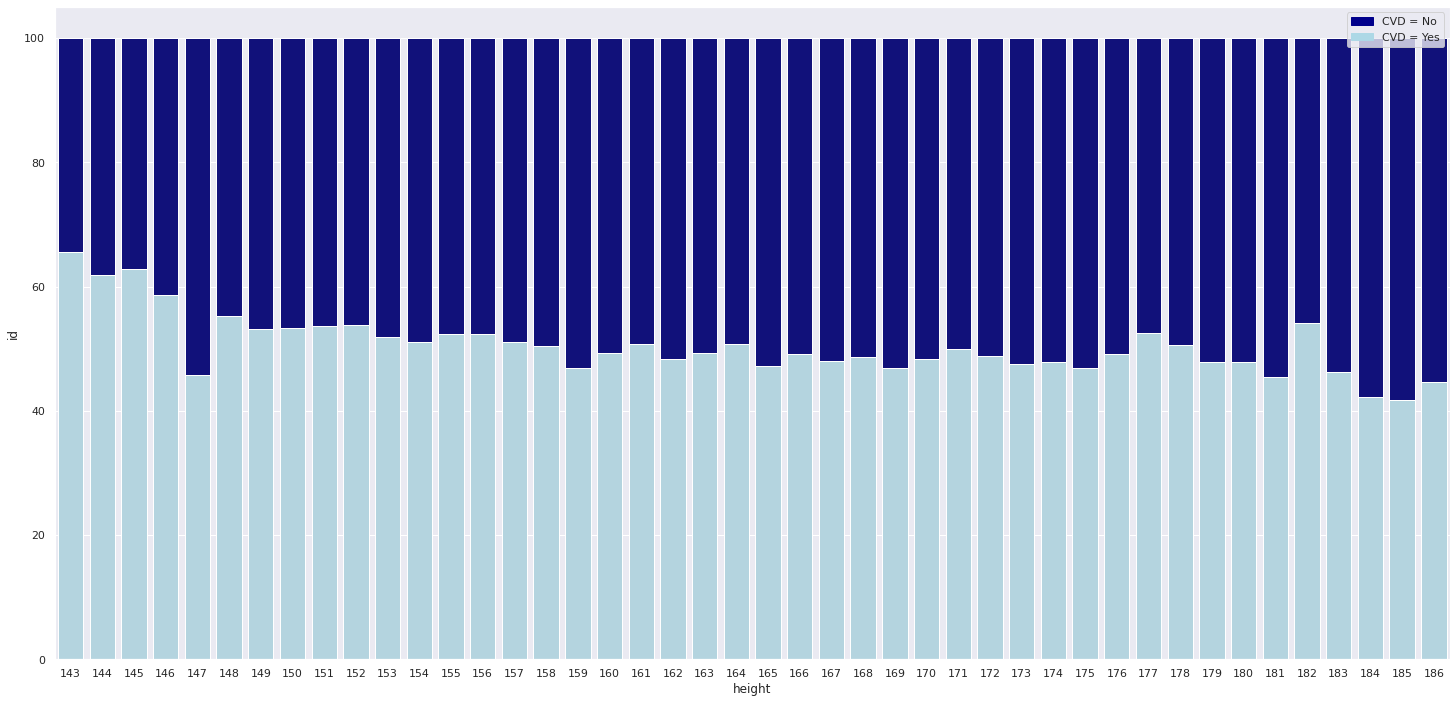

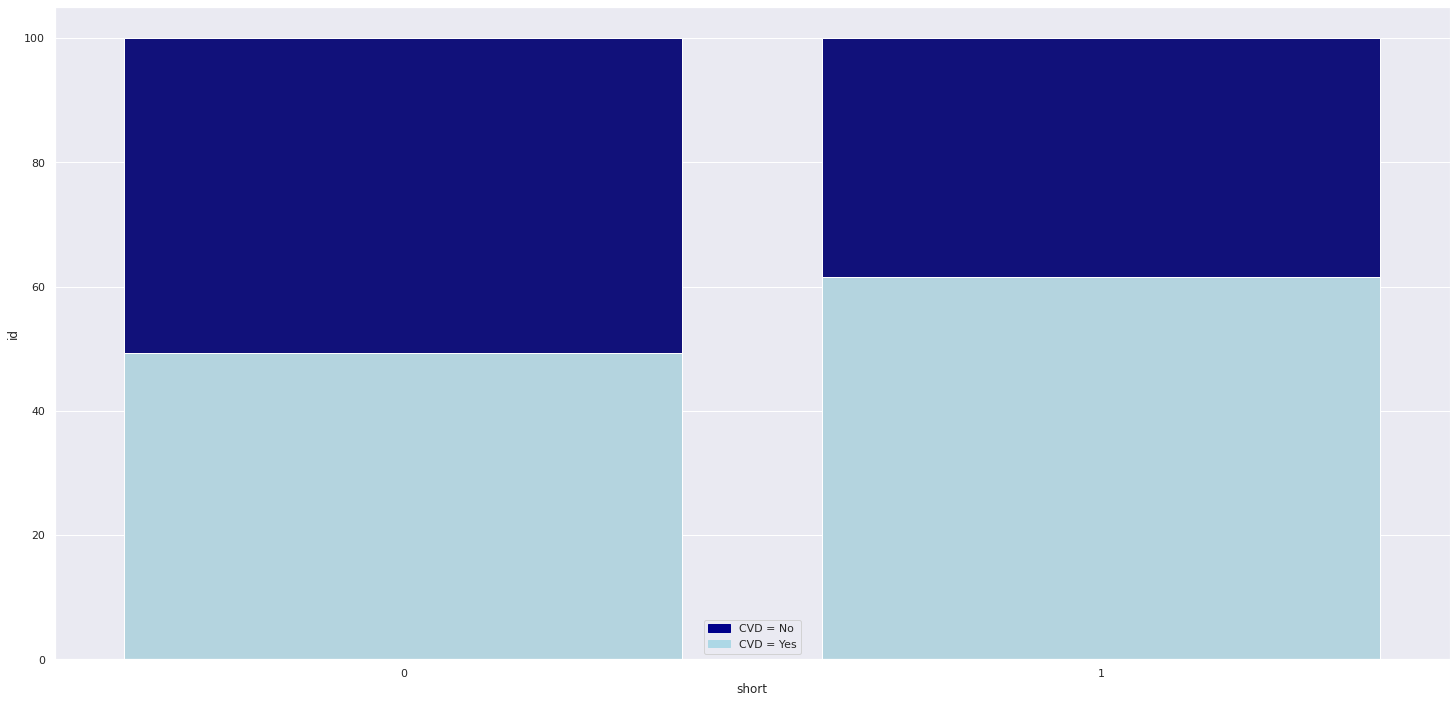

In [41]:

stacked_barplot(df3, 'height')

aux = df3.copy()
aux['short'] = aux['height'].apply(lambda x: 1 if x < 147 else 0)


stacked_barplot(aux, 'short')

### H4. The likelihood to develop a CVD  should increase with the blood pressure
**TRUE** The likelihood to develop a CVD increases with the blood pressure

<AxesSubplot:xlabel='ap_lo', ylabel='Count'>

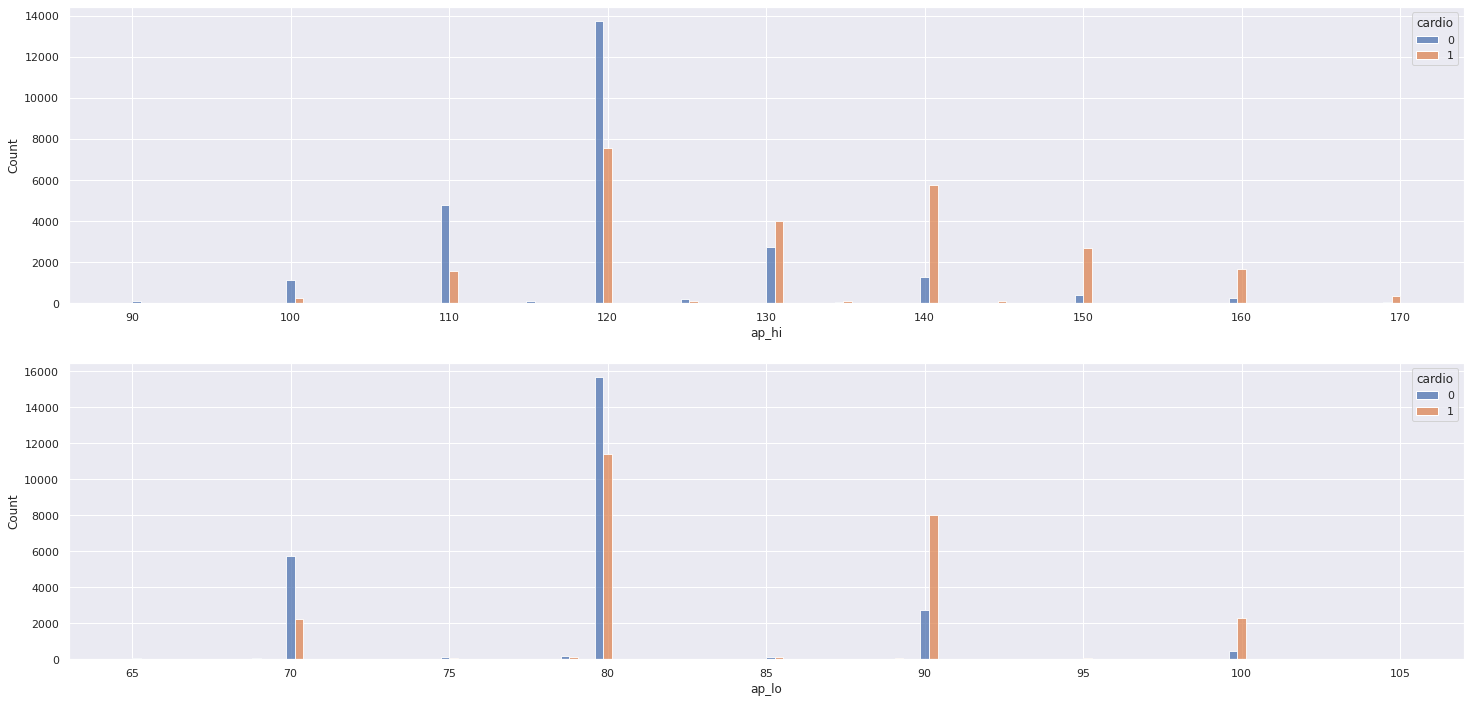

In [42]:
plt.subplot(2,1,1)
sns.histplot(x='ap_hi', hue='cardio', multiple='dodge', data=df3)

plt.subplot(2,1,2)
sns.histplot(x='ap_lo', hue='cardio', multiple='dodge', data=df3)

### H5. The likelihood  of a person to develop a CVD  should increase with the glucose levels
**TRUE** The likelihood of a person to develop a CVD increases with the glucose levels

<AxesSubplot:xlabel='gluc', ylabel='count'>

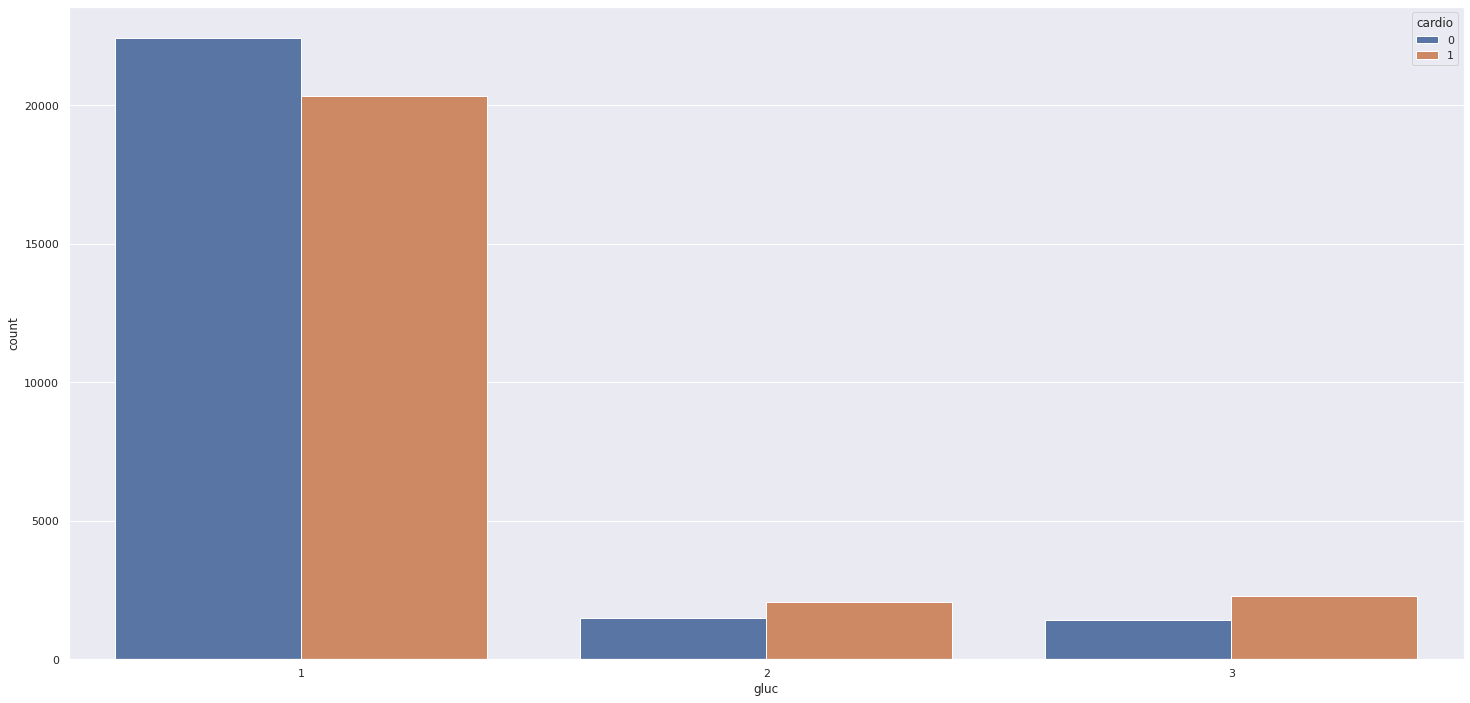

In [43]:
sns.countplot(x='gluc', hue='cardio', data=df3)

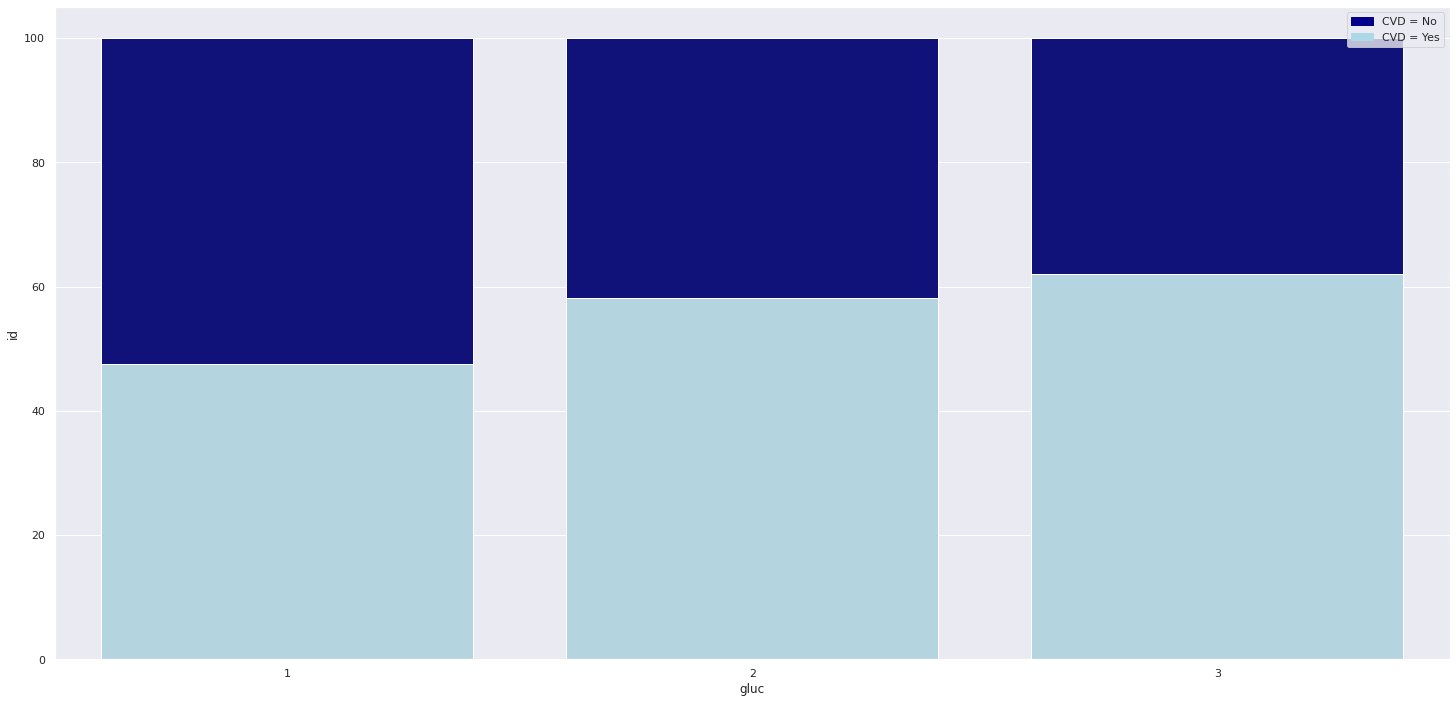

In [44]:
stacked_barplot(df3 , 'gluc')

### H6. The likelihood  of a person to develop a CVD  should increase with the cholesterol levels
**TRUE** The likelihood of a person to develop a CVD increases with the cholesterol levels

<AxesSubplot:xlabel='cholesterol', ylabel='count'>

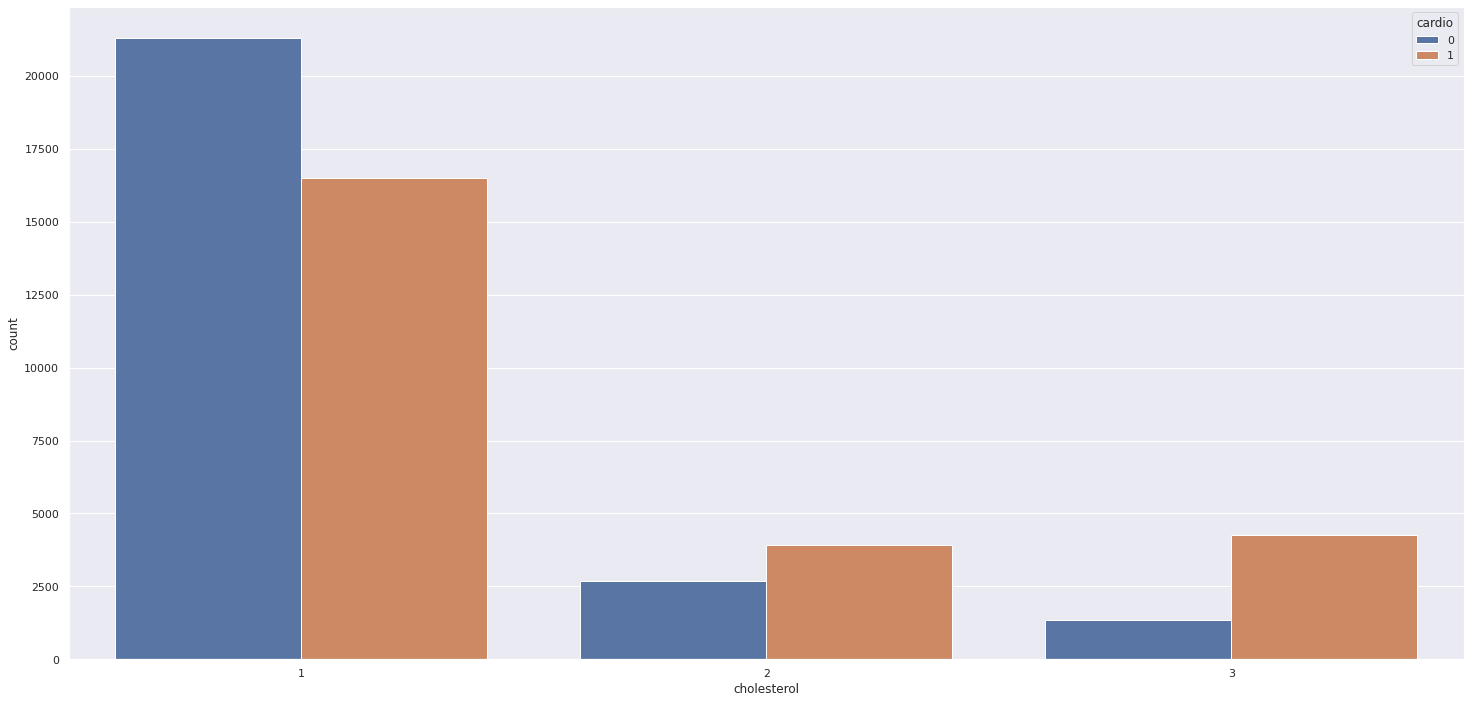

In [45]:
sns.countplot(x='cholesterol', hue='cardio', data=df3)

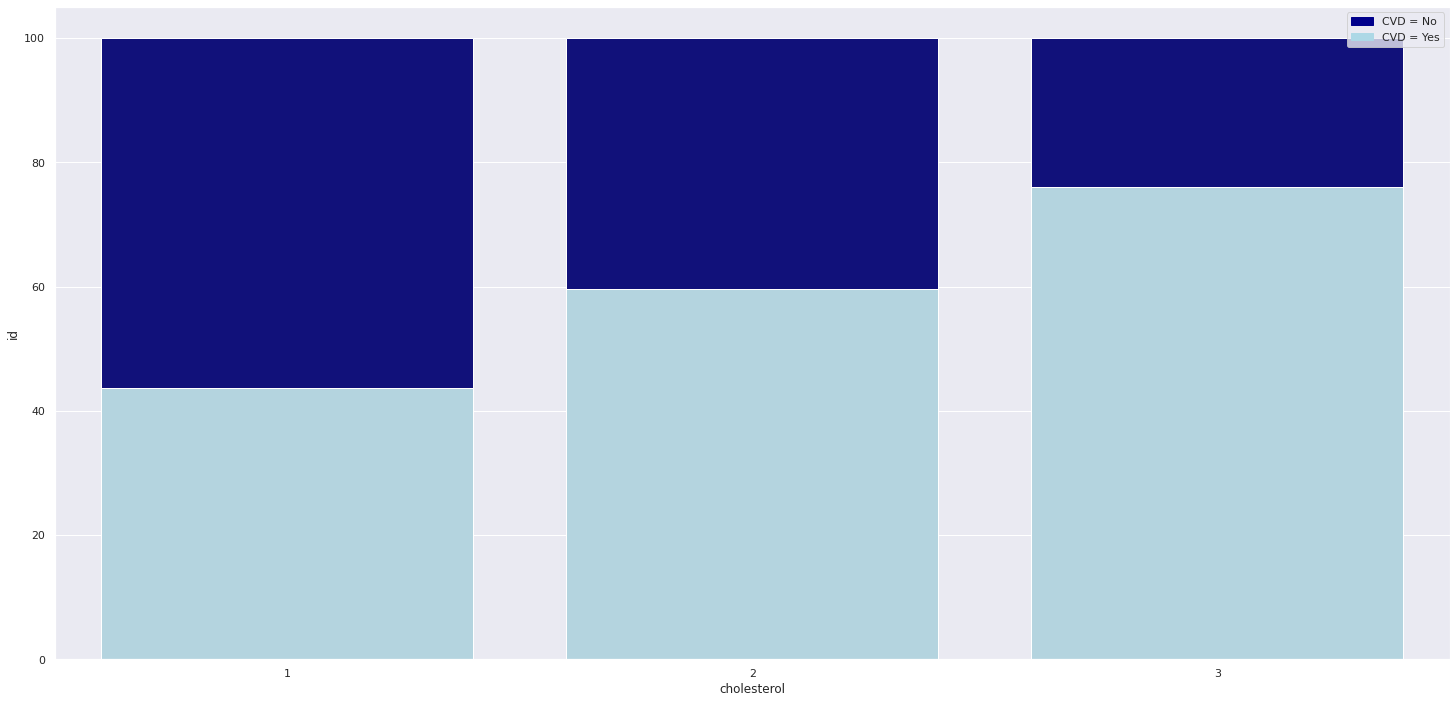

In [46]:
stacked_barplot(df3, 'cholesterol')

### H7. The likelihood for a person to have a CVD should increase with the bmi
**TRUE** The likelihood for a person to have a CVD increases with the bmi 

<AxesSubplot:xlabel='obesity', ylabel='count'>

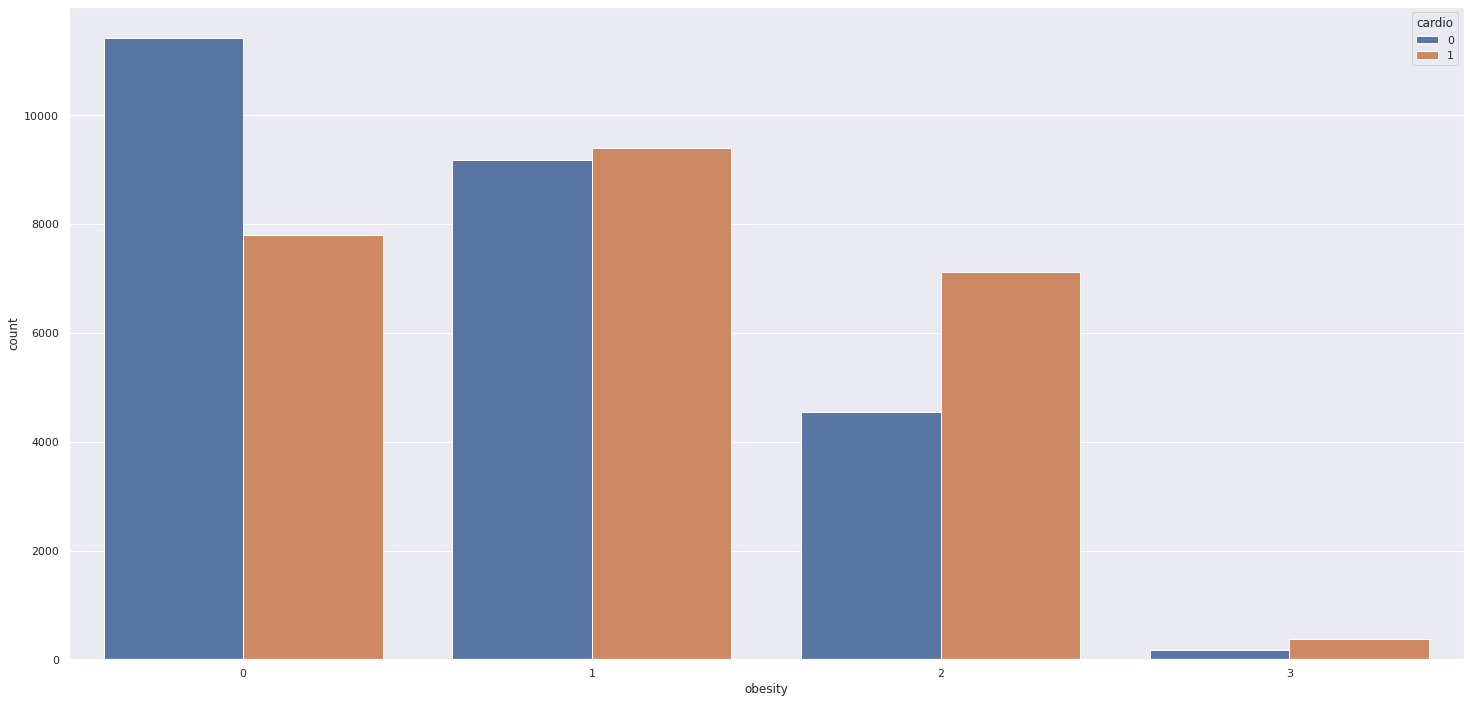

In [47]:
sns.countplot(x='obesity', hue='cardio', data=df3)

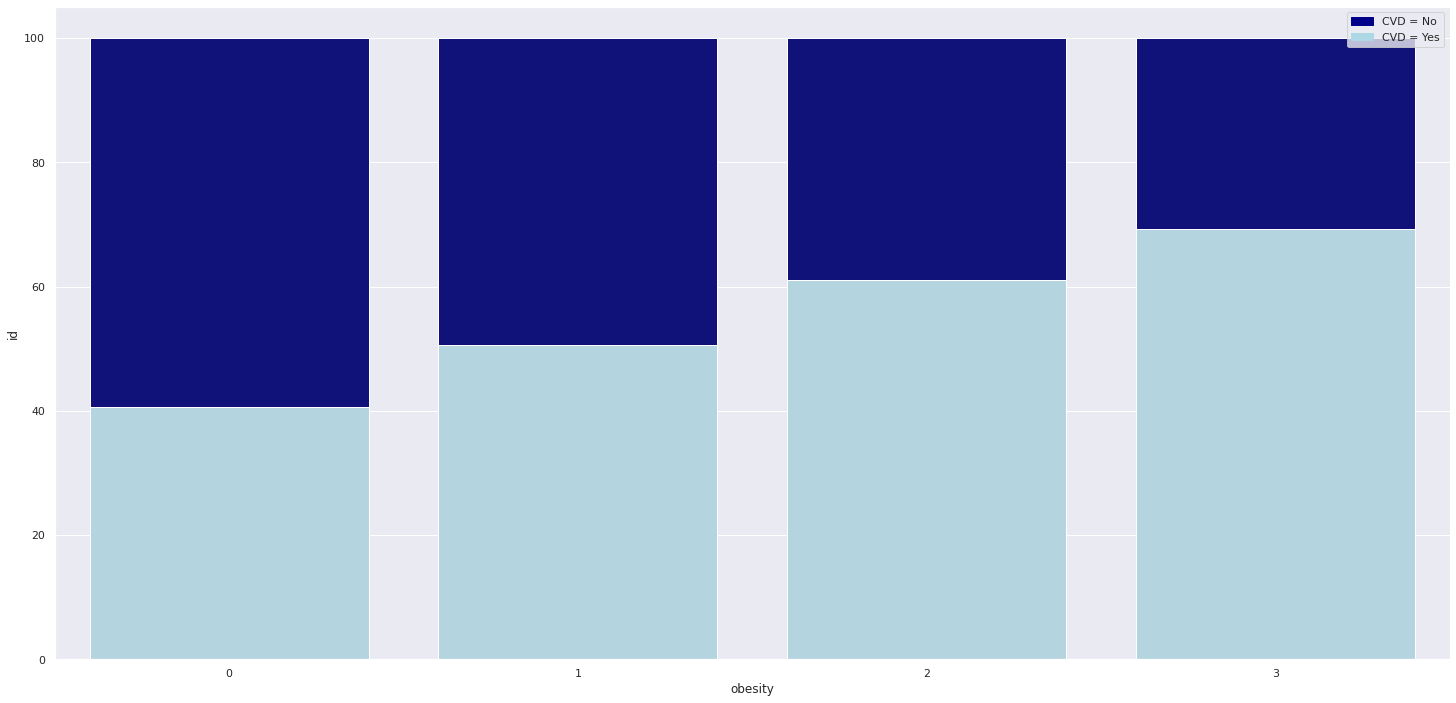

In [48]:
stacked_barplot(df3, 'obesity')

<AxesSubplot:xlabel='bmi', ylabel='Count'>

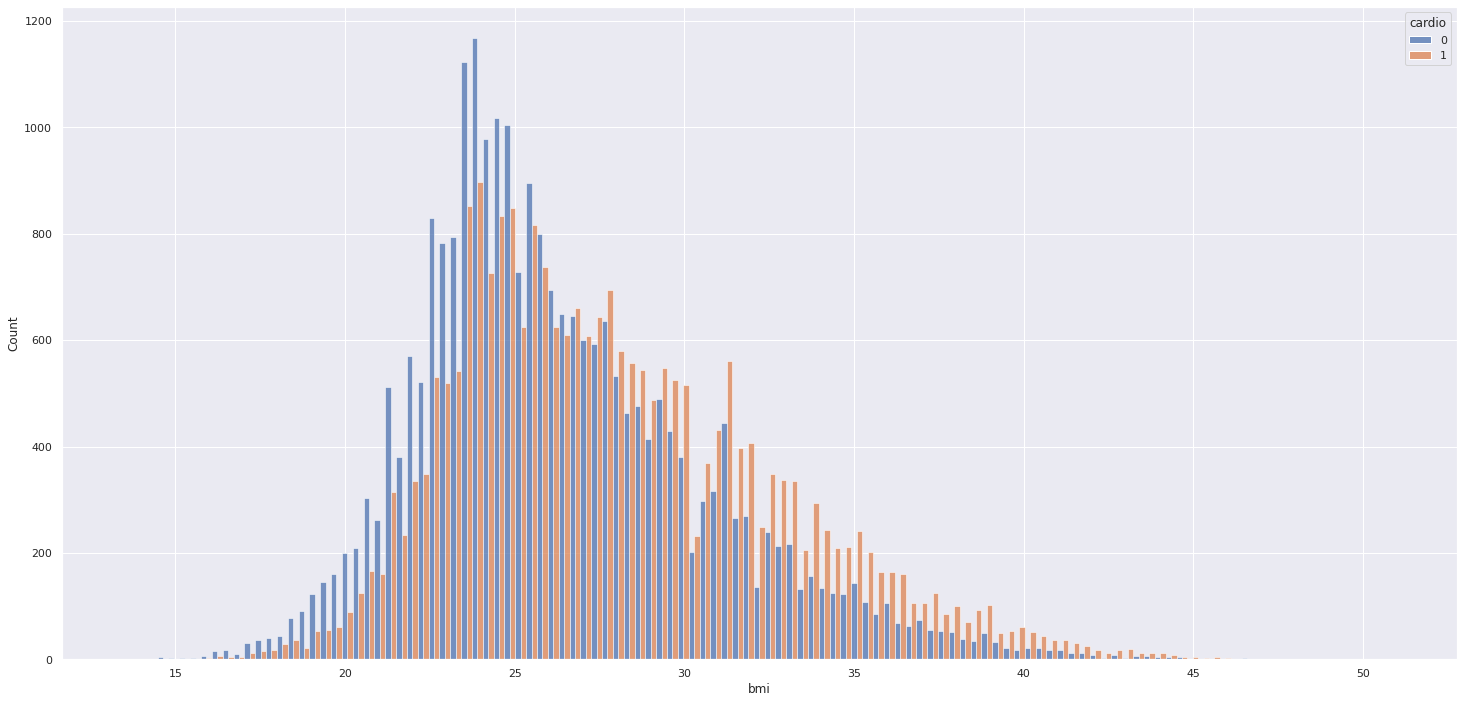

In [49]:
sns.histplot(x='bmi', hue='cardio', multiple='dodge', data=df3)

### H8. No active people should be more likely to have CVD 
**FALSE** Active people are more likely to have a CVD

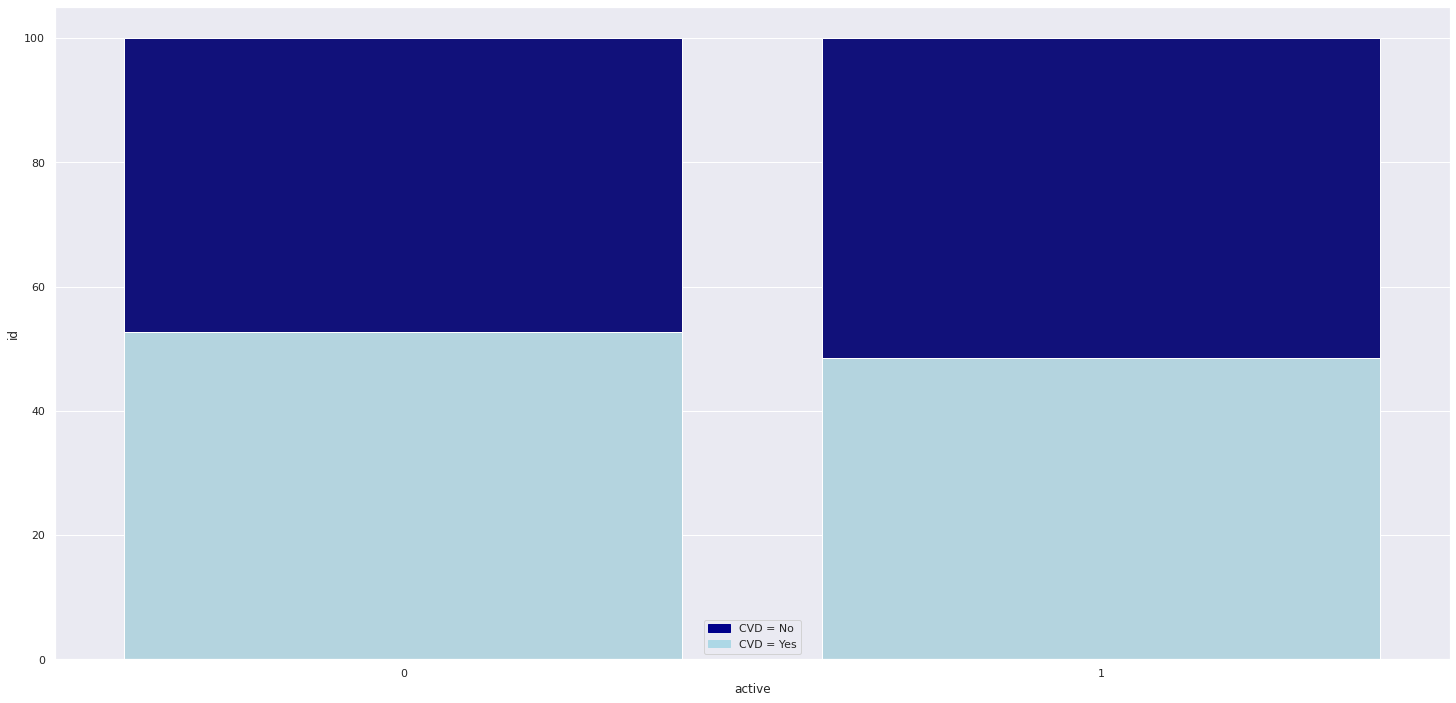

In [50]:
stacked_barplot(df3, 'active')

### H9. Smokers should be more likely to have a CVD 
**FALSE** No smokers are more likely to have a CVD

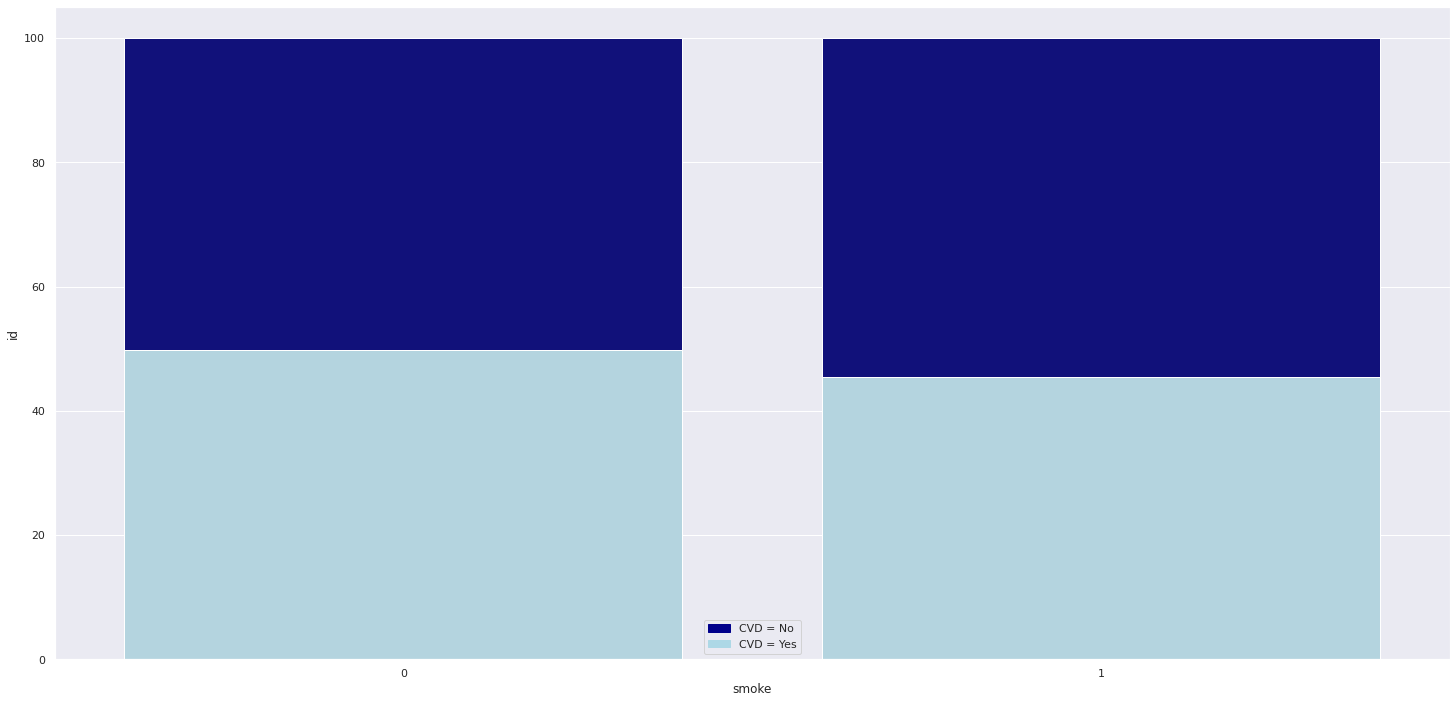

In [51]:
stacked_barplot(df3, 'smoke')

### H10.  People who drinks alcohol are more likely to develop CVD 
**FALSE** People who doesn't drink alcohol are more likely to have a CVD, but is about the same probabilty that the drinkers

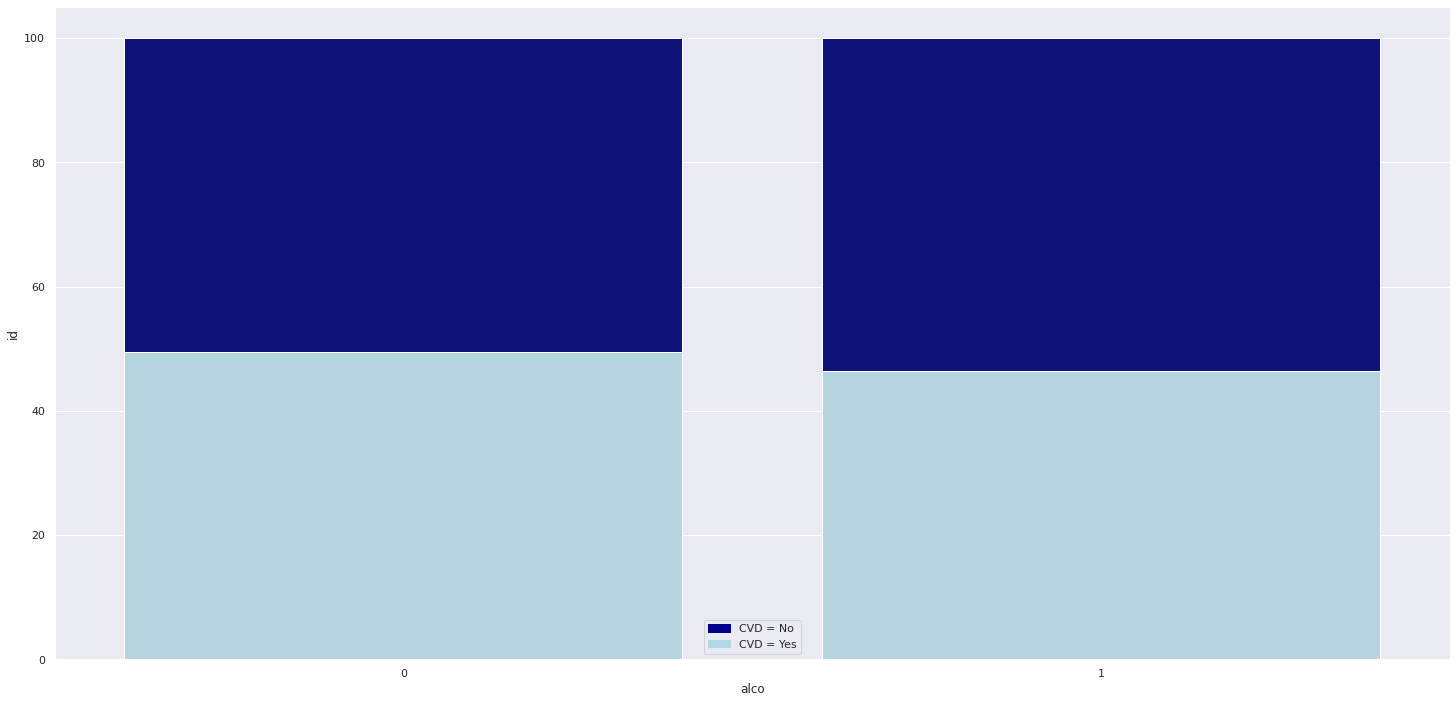

46.36% of the alcohol drinkers and 49.54% of the non drinkers has a CVD


In [52]:
stacked_barplot(df3, 'alco')

total_alco = aux[(aux['alco'] == 1)]['alco'].count()
alco_cvd = aux[(aux['alco'] == 1) & (aux['cardio'] == 1)]['alco'].count()
p_alco_cvd = round((alco_cvd / total_alco), 4)*100

total_noalco = aux[(aux['alco'] == 0)]['alco'].count()
noalco_cvd = aux[(aux['alco'] == 0) & (aux['cardio'] == 1)]['alco'].count()
p_noalco_cvd = round((noalco_cvd / total_noalco), 4)*100


print('{}% of the alcohol drinkers and {}% of the non drinkers has a CVD'.format(p_alco_cvd, p_noalco_cvd))

Data gotten by examination are more reliable than others such as smoking, activeness and drinking information because the patient can lie

## Multivarite Analysis

### Numerical features

In [53]:
df3.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,hypertension,bmi,obesity
0,67617,21876,1,154,80.0,130,90,2,1,0,0,1,1,59,0,33.732501,2
1,96320,16717,2,162,70.0,140,90,1,1,0,0,0,1,45,1,26.672763,1
2,17571,21128,2,174,92.0,150,100,1,1,0,0,1,1,57,1,30.387105,2
3,46492,23366,2,173,76.0,120,82,1,1,0,0,1,1,64,0,25.393431,1
4,945,20281,1,160,60.0,120,80,1,1,0,0,1,0,55,0,23.437500,0


In [54]:
df3.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'age_years',
       'hypertension', 'bmi', 'obesity'],
      dtype='object')

<AxesSubplot:>

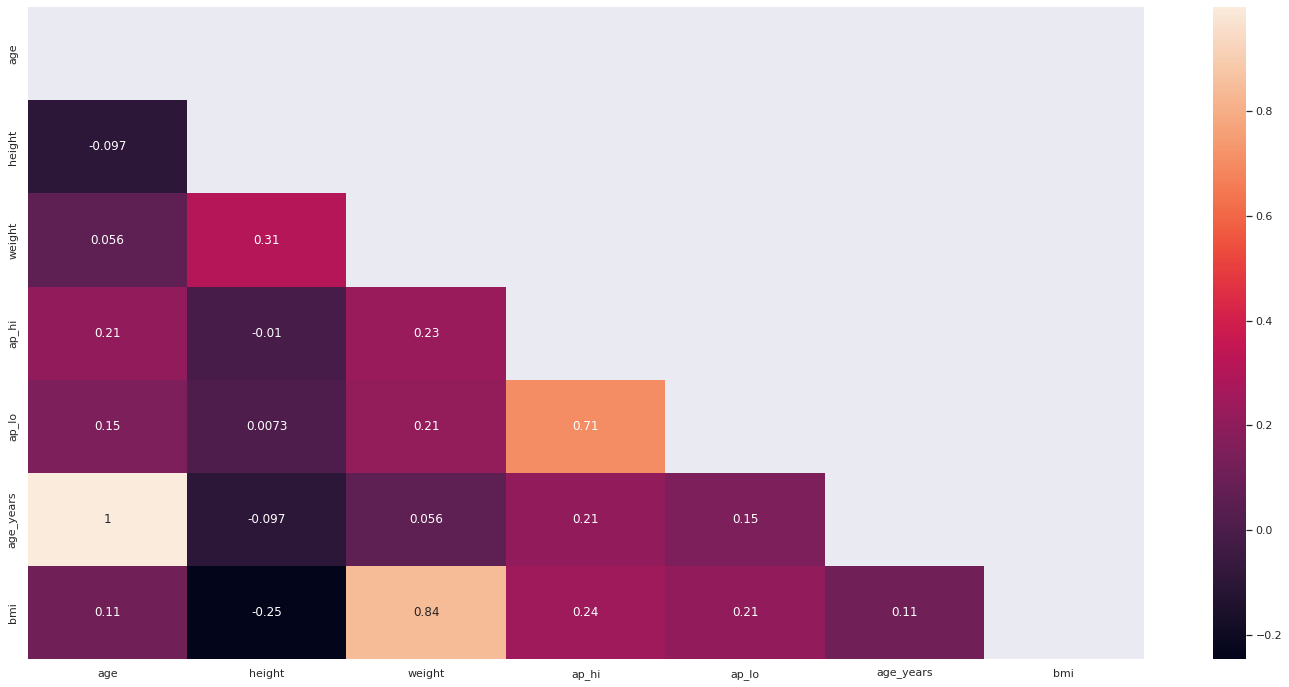

In [55]:
# need to fix by categorical and numerical


num_attributes = df3[['age','height', 'weight', 'ap_hi', 'ap_lo', 'age_years', 'bmi']]
correlation = num_attributes.corr( method='pearson' )
# generates a mask for the upper triangle
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap( correlation, mask=mask, annot=True )

### Categorical features

In [56]:
df3.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'age_years',
       'hypertension', 'bmi', 'obesity'],
      dtype='object')

<AxesSubplot:>

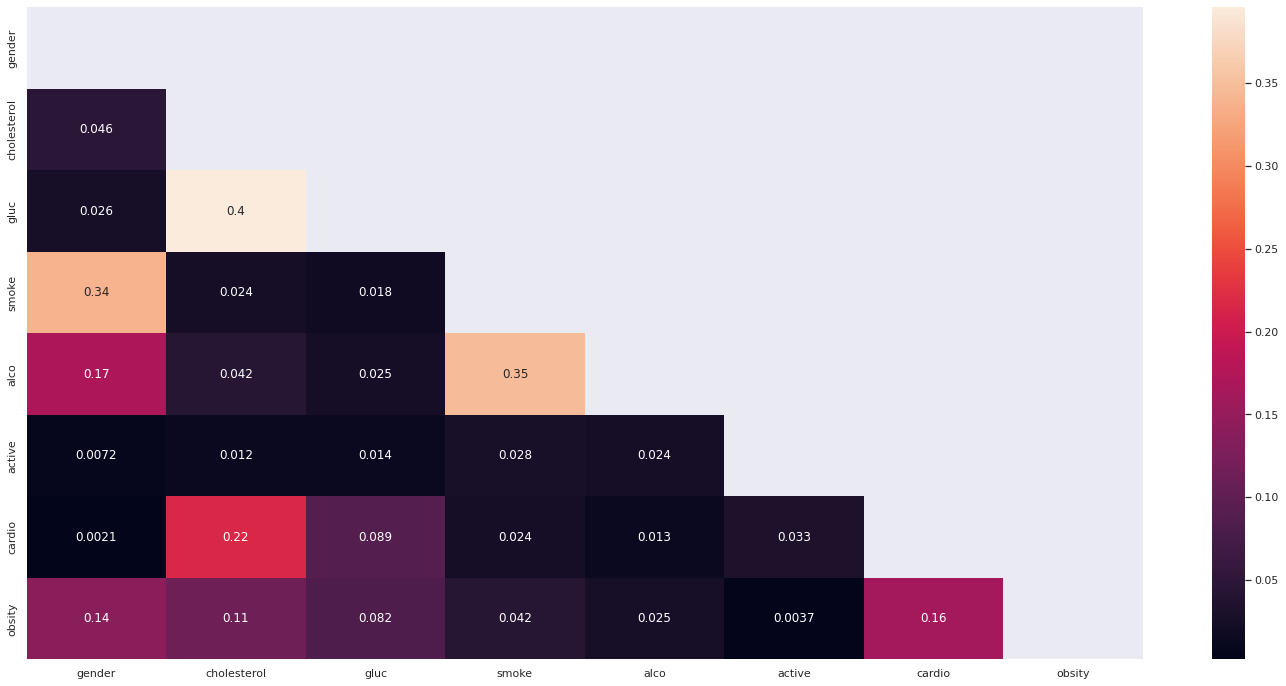

In [57]:
a = df3[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'obesity']]

# cramer's-V
a1 = dy.cramers_v(a['gender'], a['gender'])
a2 = dy.cramers_v(a['gender'], a['cholesterol'])
a3 = dy.cramers_v(a['gender'], a['gluc'])
a4 = dy.cramers_v(a['gender'], a['smoke'])
a5 = dy.cramers_v(a['gender'], a['alco'])
a6 = dy.cramers_v(a['gender'], a['active'])
a7 = dy.cramers_v(a['gender'], a['cardio'])
a8 = dy.cramers_v(a['gender'], a['obesity'])

a9 = dy.cramers_v(a['cholesterol'], a['gender'])
a10 = dy.cramers_v(a['cholesterol'], a['cholesterol'])
a11 = dy.cramers_v(a['cholesterol'], a['gluc'])
a12 = dy.cramers_v(a['cholesterol'], a['smoke'])
a13 = dy.cramers_v(a['cholesterol'], a['alco'])
a14 = dy.cramers_v(a['cholesterol'], a['active'])
a15 = dy.cramers_v(a['cholesterol'], a['cardio'])
a16 = dy.cramers_v(a['cholesterol'], a['obesity'])



a17 = dy.cramers_v(a['gluc'], a['gender'])
a18 = dy.cramers_v(a['gluc'], a['cholesterol'])
a19 = dy.cramers_v(a['gluc'], a['gluc'])
a20 = dy.cramers_v(a['gluc'], a['smoke'])
a21 = dy.cramers_v(a['gluc'], a['alco'])
a22 = dy.cramers_v(a['gluc'], a['active'])
a23 = dy.cramers_v(a['gluc'], a['cardio'])
a24 = dy.cramers_v(a['gluc'], a['obesity'])



a25 = dy.cramers_v(a['smoke'], a['gender'])
a26 = dy.cramers_v(a['smoke'], a['cholesterol'])
a27 = dy.cramers_v(a['smoke'], a['gluc'])
a28 = dy.cramers_v(a['smoke'], a['smoke'])
a29 = dy.cramers_v(a['smoke'], a['alco'])
a30 = dy.cramers_v(a['smoke'], a['active'])
a31 = dy.cramers_v(a['smoke'], a['cardio'])
a32 = dy.cramers_v(a['smoke'], a['obesity'])



a33 = dy.cramers_v(a['alco'], a['gender'])
a34 = dy.cramers_v(a['alco'], a['cholesterol'])
a35 = dy.cramers_v(a['alco'], a['gluc'])
a36 = dy.cramers_v(a['alco'], a['smoke'])
a37 = dy.cramers_v(a['alco'], a['alco'])
a38 = dy.cramers_v(a['alco'], a['active'])
a39 = dy.cramers_v(a['alco'], a['cardio'])
a40 = dy.cramers_v(a['alco'], a['obesity'])



a41 = dy.cramers_v(a['active'], a['gender'])
a42 = dy.cramers_v(a['active'], a['cholesterol'])
a43 = dy.cramers_v(a['active'], a['gluc'])
a44 = dy.cramers_v(a['active'], a['smoke'])
a45 = dy.cramers_v(a['active'], a['alco'])
a46 = dy.cramers_v(a['active'], a['active'])
a47 = dy.cramers_v(a['active'], a['cardio'])
a48 = dy.cramers_v(a['active'], a['obesity'])

a49 = dy.cramers_v(a['cardio'], a['gender'])
a50 = dy.cramers_v(a['cardio'], a['cholesterol'])
a51 = dy.cramers_v(a['cardio'], a['gluc'])
a52 = dy.cramers_v(a['cardio'], a['smoke'])
a53 = dy.cramers_v(a['cardio'], a['alco'])
a54 = dy.cramers_v(a['cardio'], a['active'])
a55 = dy.cramers_v(a['cardio'], a['cardio'])
a56 = dy.cramers_v(a['cardio'], a['obesity'])


a57 = dy.cramers_v(a['obesity'], a['gender'])
a58 = dy.cramers_v(a['obesity'], a['cholesterol'])
a59 = dy.cramers_v(a['obesity'], a['gluc'])
a60 = dy.cramers_v(a['obesity'], a['smoke'])
a61 = dy.cramers_v(a['obesity'], a['alco'])
a62 = dy.cramers_v(a['obesity'], a['active'])
a63 = dy.cramers_v(a['obesity'], a['cardio'])
a64 = dy.cramers_v(a['obesity'], a['obesity'])



# Final dataset
d = pd.DataFrame({'gender': [a1, a2, a3, a4, a5, a6, a7, a8],
                  'cholesterol': [a9, a10, a11, a12, a13, a14, a15, a16],
                  'gluc': [a17, a18, a19, a20, a21, a22, a23, a24],
                  'smoke': [a25, a26, a27, a28, a29, a30, a31, a32],
                  'alco': [a33, a34, a35, a36, a37, a38, a39, a40],
                  'active': [a41, a42, a43, a44, a45, a46, a47, a48],
                  'cardio': [a49, a50, a51, a52, a53, a54, a55, a56],
                  'obsity': [a57, a58, a59, a60, a61, a62, a63, a64]} )


d = d.set_index( d.columns )

mask = np.triu(np.ones_like(d, dtype=bool))
sns.heatmap( d, mask = mask , annot=True )



<AxesSubplot:>

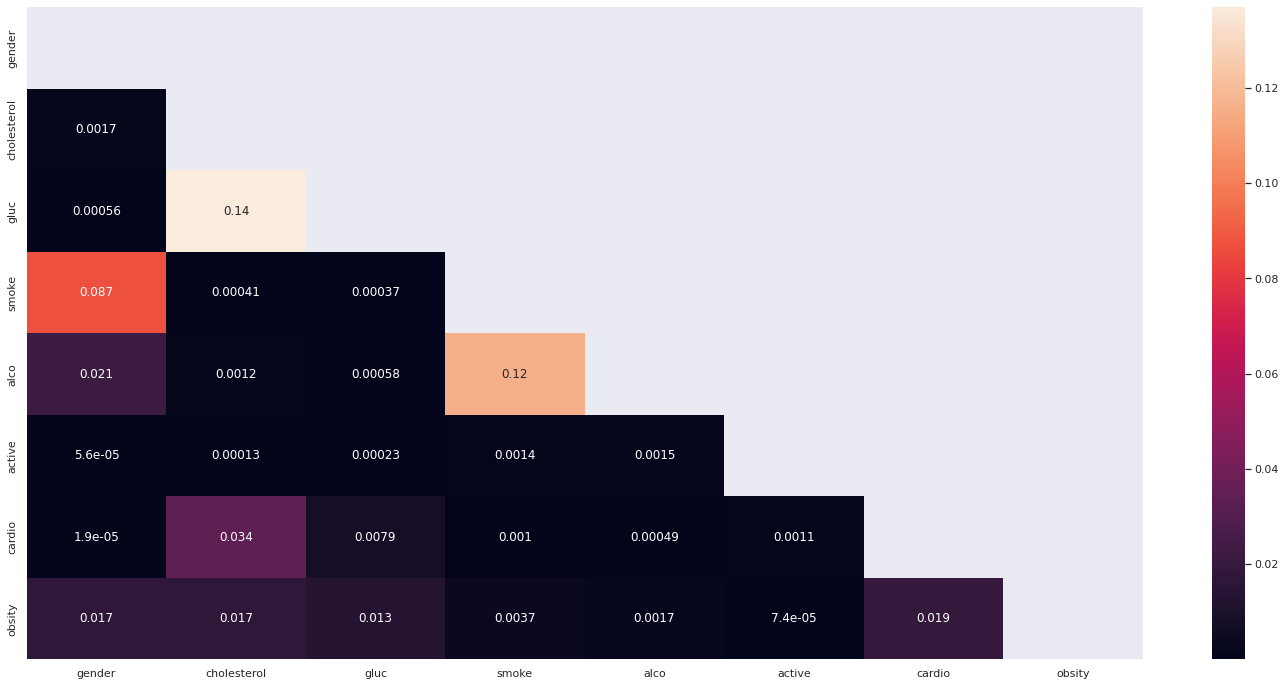

In [58]:
# Theils-u
a1 = dy.theils_u(a['gender'], a['gender'])
a2 = dy.theils_u(a['gender'], a['cholesterol'])
a3 = dy.theils_u(a['gender'], a['gluc'])
a4 = dy.theils_u(a['gender'], a['smoke'])
a5 = dy.theils_u(a['gender'], a['alco'])
a6 = dy.theils_u(a['gender'], a['active'])
a7 = dy.theils_u(a['gender'], a['cardio'])
a8 = dy.theils_u(a['gender'], a['obesity'])


a10 = dy.theils_u(a['cholesterol'], a['gender'])
a10 = dy.theils_u(a['cholesterol'], a['cholesterol'])
a11 = dy.theils_u(a['cholesterol'], a['gluc'])
a12 = dy.theils_u(a['cholesterol'], a['smoke'])
a13 = dy.theils_u(a['cholesterol'], a['alco'])
a14 = dy.theils_u(a['cholesterol'], a['active'])
a15 = dy.theils_u(a['cholesterol'], a['cardio'])
a16 = dy.theils_u(a['cholesterol'], a['obesity'])



a17 = dy.theils_u(a['gluc'], a['gender'])
a18 = dy.theils_u(a['gluc'], a['cholesterol'])
a19 = dy.theils_u(a['gluc'], a['gluc'])
a20 = dy.theils_u(a['gluc'], a['smoke'])
a21 = dy.theils_u(a['gluc'], a['alco'])
a22 = dy.theils_u(a['gluc'], a['active'])
a23 = dy.theils_u(a['gluc'], a['cardio'])
a24 = dy.theils_u(a['gluc'], a['obesity'])



a25 = dy.theils_u(a['smoke'], a['gender'])
a26 = dy.theils_u(a['smoke'], a['cholesterol'])
a27 = dy.theils_u(a['smoke'], a['gluc'])
a28 = dy.theils_u(a['smoke'], a['smoke'])
a29 = dy.theils_u(a['smoke'], a['alco'])
a30 = dy.theils_u(a['smoke'], a['active'])
a31 = dy.theils_u(a['smoke'], a['cardio'])
a32 = dy.theils_u(a['smoke'], a['obesity'])



a33 = dy.theils_u(a['alco'], a['gender'])
a34 = dy.theils_u(a['alco'], a['cholesterol'])
a35 = dy.theils_u(a['alco'], a['gluc'])
a36 = dy.theils_u(a['alco'], a['smoke'])
a37 = dy.theils_u(a['alco'], a['alco'])
a38 = dy.theils_u(a['alco'], a['active'])
a39 = dy.theils_u(a['alco'], a['cardio'])
a40 = dy.theils_u(a['alco'], a['obesity'])



a41 = dy.theils_u(a['active'], a['gender'])
a42 = dy.theils_u(a['active'], a['cholesterol'])
a43 = dy.theils_u(a['active'], a['gluc'])
a44 = dy.theils_u(a['active'], a['smoke'])
a45 = dy.theils_u(a['active'], a['alco'])
a46 = dy.theils_u(a['active'], a['active'])
a47 = dy.theils_u(a['active'], a['cardio'])
a48 = dy.theils_u(a['active'], a['obesity'])

a49 = dy.theils_u(a['cardio'], a['gender'])
a50 = dy.theils_u(a['cardio'], a['cholesterol'])
a51 = dy.theils_u(a['cardio'], a['gluc'])
a52 = dy.theils_u(a['cardio'], a['smoke'])
a53 = dy.theils_u(a['cardio'], a['alco'])
a54 = dy.theils_u(a['cardio'], a['active'])
a55 = dy.theils_u(a['cardio'], a['cardio'])
a56 = dy.theils_u(a['cardio'], a['obesity'])


a57 = dy.theils_u(a['obesity'], a['gender'])
a58 = dy.theils_u(a['obesity'], a['cholesterol'])
a59 = dy.theils_u(a['obesity'], a['gluc'])
a60 = dy.theils_u(a['obesity'], a['smoke'])
a61 = dy.theils_u(a['obesity'], a['alco'])
a62 = dy.theils_u(a['obesity'], a['active'])
a63 = dy.theils_u(a['obesity'], a['cardio'])
a64 = dy.theils_u(a['obesity'], a['obesity'])



# Final dataset
d = pd.DataFrame({'gender': [a1, a2, a3, a4, a5, a6, a7, a8],
                  'cholesterol': [a9, a10, a11, a12, a13, a14, a15, a16],
                  'gluc': [a17, a18, a19, a20, a21, a22, a23, a24],
                  'smoke': [a25, a26, a27, a28, a29, a30, a31, a32],
                  'alco': [a33, a34, a35, a36, a37, a38, a39, a40],
                  'active': [a41, a42, a43, a44, a45, a46, a47, a48],
                  'cardio': [a49, a50, a51, a52, a53, a54, a55, a56],
                  'obsity': [a57, a58, a59, a60, a61, a62, a63, a64]} )


d = d.set_index( d.columns )

mask = np.triu(np.ones_like(d, dtype=bool))
sns.heatmap( d, mask = mask , annot=True )



### Numerical and categorical:

In [59]:
num_attributes = ['age','height', 'weight', 'ap_hi', 'ap_lo', 'age_years', 'bmi']
cat_attributes = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'obesity']

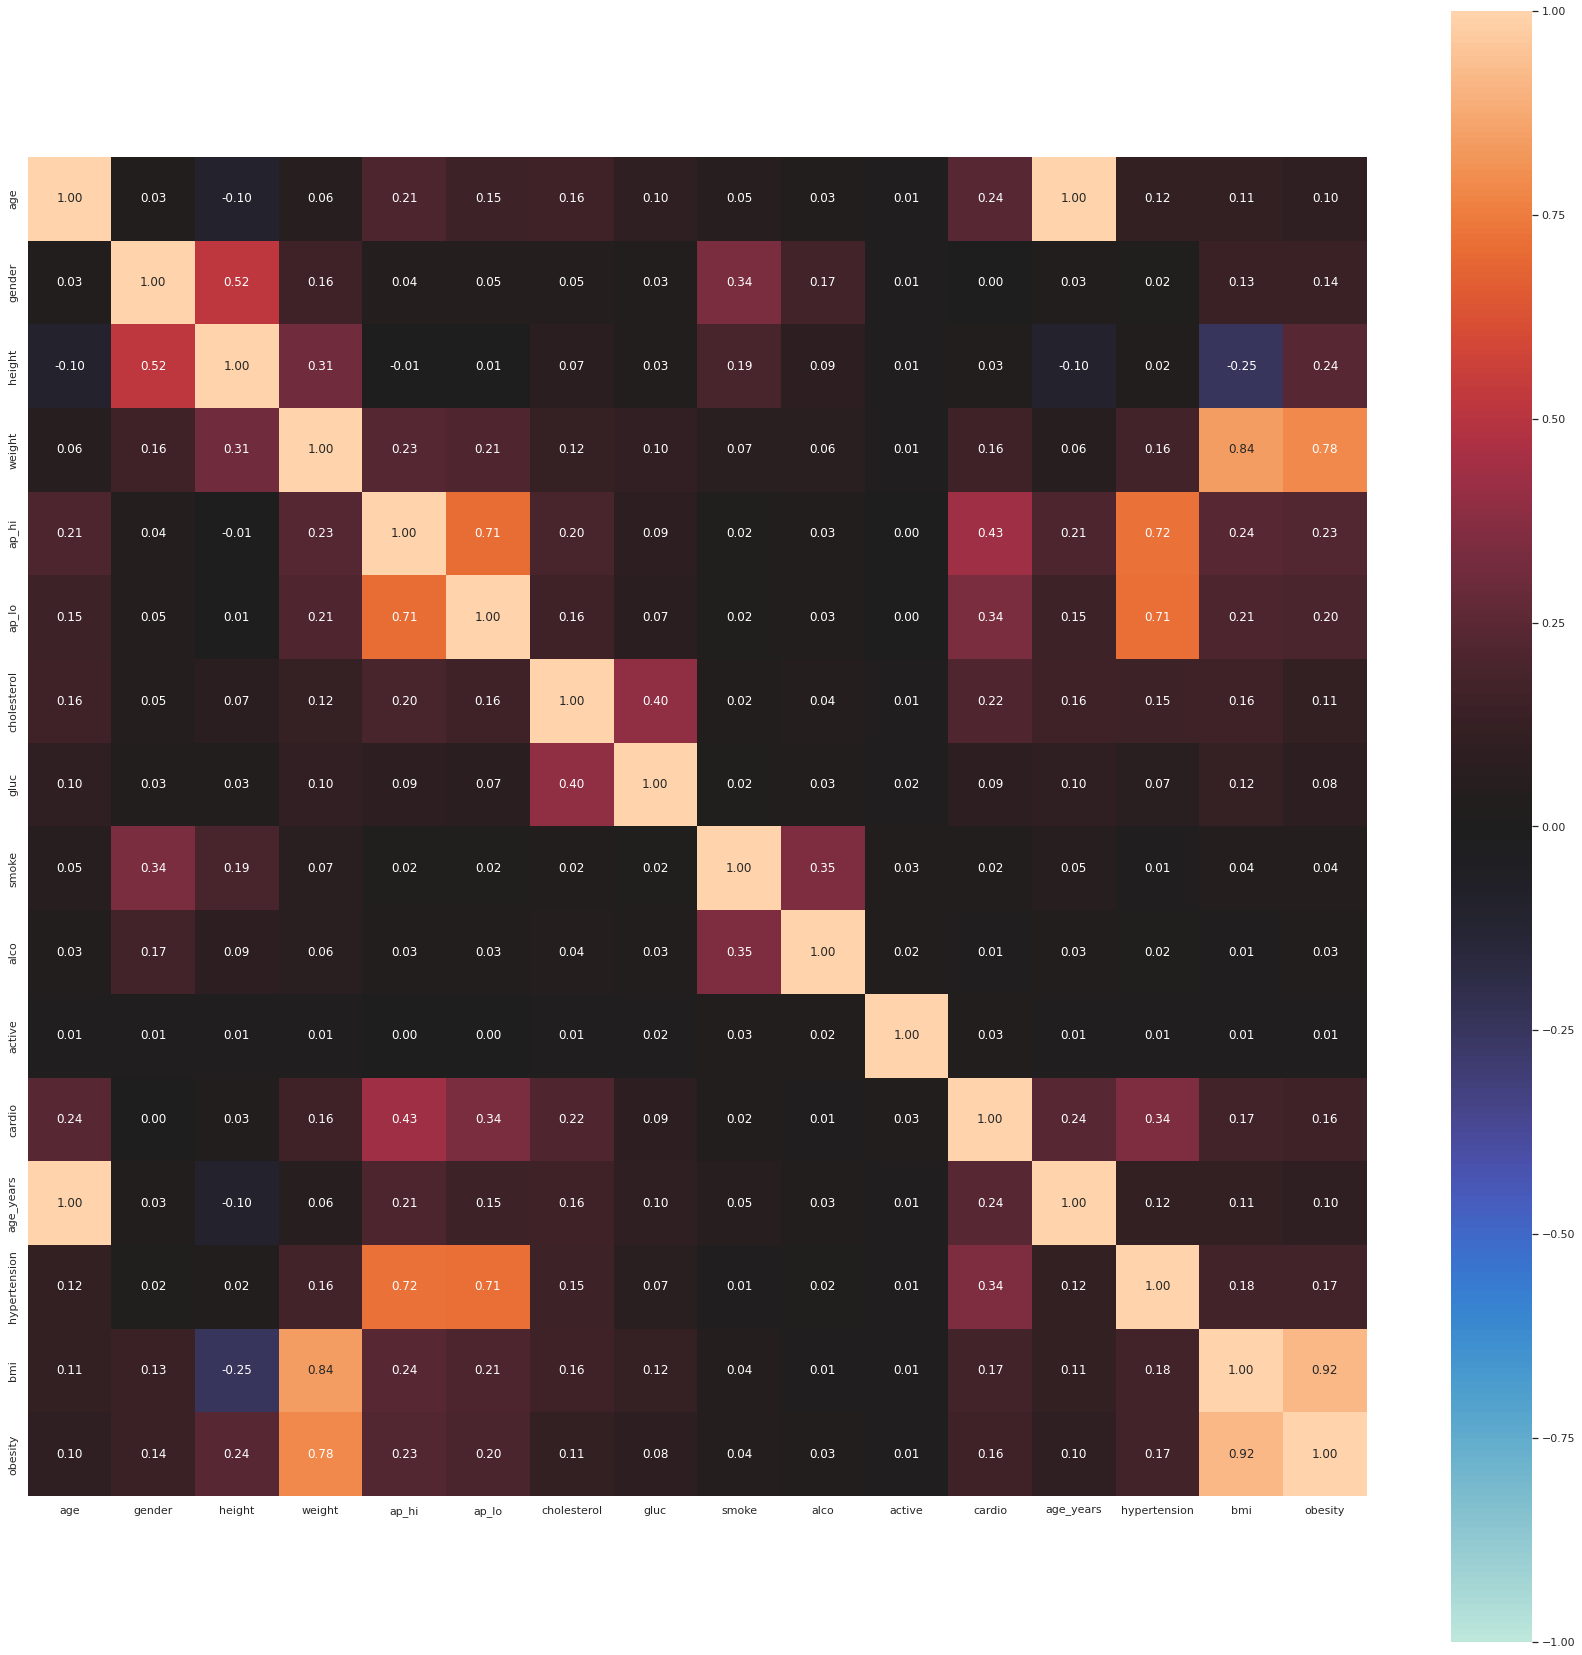

{'corr':                    age    gender    height    weight     ap_hi     ap_lo  cholesterol      gluc     smoke      alco    active    cardio  age_years  hypertension       bmi   obesity
 age           1.000000  0.032487 -0.097364  0.056048  0.206902  0.149158     0.156791  0.097438  0.047179  0.027140  0.011083  0.235411   0.999084      0.115644  0.111931  0.101520
 gender        0.032487  1.000000  0.515942  0.156386  0.041458  0.046064     0.046169  0.026691  0.338326  0.171349  0.008445  0.004929   0.032634      0.019779  0.132816  0.137806
 height       -0.097364  0.515942  1.000000  0.305317 -0.010478  0.007306     0.070713  0.030305  0.192089  0.092732  0.008813  0.027281  -0.097370      0.023683 -0.247118  0.239163
 weight        0.056048  0.156386  0.305317  1.000000  0.231413  0.211129     0.122769  0.102421  0.065128  0.064719  0.014032  0.156467   0.055862      0.164660  0.843294  0.783724
 ap_hi         0.206902  0.041458 -0.010478  0.231413  1.000000  0.705869     0.19

In [60]:
# numerical x numerical = pearsons
# cat x cat = cramers
# num x cat = correlations_ratio


dy.associations(df3.drop(columns=['id']), nominal_columns = cat_attributes, numerical_columns = num_attributes, bias_correction=False, figsize=(30,30))

# Data preparation

In [61]:
df4 = df3.copy()

In [62]:
df4.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,hypertension,bmi,obesity
0,67617,21876,1,154,80.0,130,90,2,1,0,0,1,1,59,0,33.732501,2
1,96320,16717,2,162,70.0,140,90,1,1,0,0,0,1,45,1,26.672763,1
2,17571,21128,2,174,92.0,150,100,1,1,0,0,1,1,57,1,30.387105,2
3,46492,23366,2,173,76.0,120,82,1,1,0,0,1,1,64,0,25.393431,1
4,945,20281,1,160,60.0,120,80,1,1,0,0,1,0,55,0,23.437500,0


## Train test split

In [63]:
X = df4.drop(columns=['id','cardio','hypertension', 'obesity', 'age_years'])
y = df4['cardio']


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [64]:
x_train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi
53452,18259,1,150,70.0,110,70,2,1,0,0,1,31.111111
5969,20429,2,158,72.0,120,80,1,1,0,0,1,28.841532
33196,21857,1,168,74.0,140,90,1,1,0,0,1,26.218821
48718,21942,2,162,76.0,110,70,3,1,0,0,1,28.959000
43431,21726,1,160,85.0,150,90,1,1,0,0,1,33.203125


## Rescaling

In [65]:
# rescaling after data split because of data leak
# define min max scaler - Im going to use mms because in this cycle Im dropped my outliers
mms = MinMaxScaler()

#age 
x_train['age'] = mms.fit_transform(x_train[['age']].values)
x_test['age'] = mms.fit_transform(x_test[['age']].values)
X['age'] = mms.fit_transform(X[['age']].values)

#height
x_train['height'] = mms.fit_transform(x_train[['height']].values)
x_test['height'] = mms.fit_transform(x_test[['height']].values)
X['height'] = mms.fit_transform(X[['height']].values)

#weight
x_train['weight'] = mms.fit_transform(x_train[['weight']].values)
x_test['weight'] = mms.fit_transform(x_test[['weight']].values)
X['weight'] = mms.fit_transform(X[['weight']].values)


#ap_hi
x_train['ap_hi'] = mms.fit_transform(x_train[['ap_hi']].values)
x_test['ap_hi'] = mms.fit_transform(x_test[['ap_hi']].values)
X['ap_hi'] = mms.fit_transform(X[['ap_hi']].values)


#ap_lo
x_train['ap_lo'] = mms.fit_transform(x_train[['ap_lo']].values)
x_test['ap_lo'] = mms.fit_transform(x_test[['ap_lo']].values)
X['ap_lo'] = mms.fit_transform(X[['ap_lo']].values)


#bmi
#ap_lo
x_train['bmi'] = mms.fit_transform(x_train[['bmi']].values)
x_test['bmi'] = mms.fit_transform(x_test[['bmi']].values)
X['bmi'] = mms.fit_transform(X[['bmi']].values)

In [66]:
x_train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi
53452,0.575696,1,0.162791,0.447761,0.250,0.125,2,1,0,0,1,0.456043
5969,0.744515,2,0.348837,0.477612,0.375,0.375,1,1,0,0,1,0.393631
33196,0.855609,1,0.581395,0.507463,0.625,0.625,1,1,0,0,1,0.321508
48718,0.862222,2,0.441860,0.537313,0.250,0.125,3,1,0,0,1,0.396861
43431,0.845418,1,0.395349,0.671642,0.750,0.625,1,1,0,0,1,0.513572


# Feature selection

## Importance of features

<AxesSubplot:xlabel='importance', ylabel='feature'>

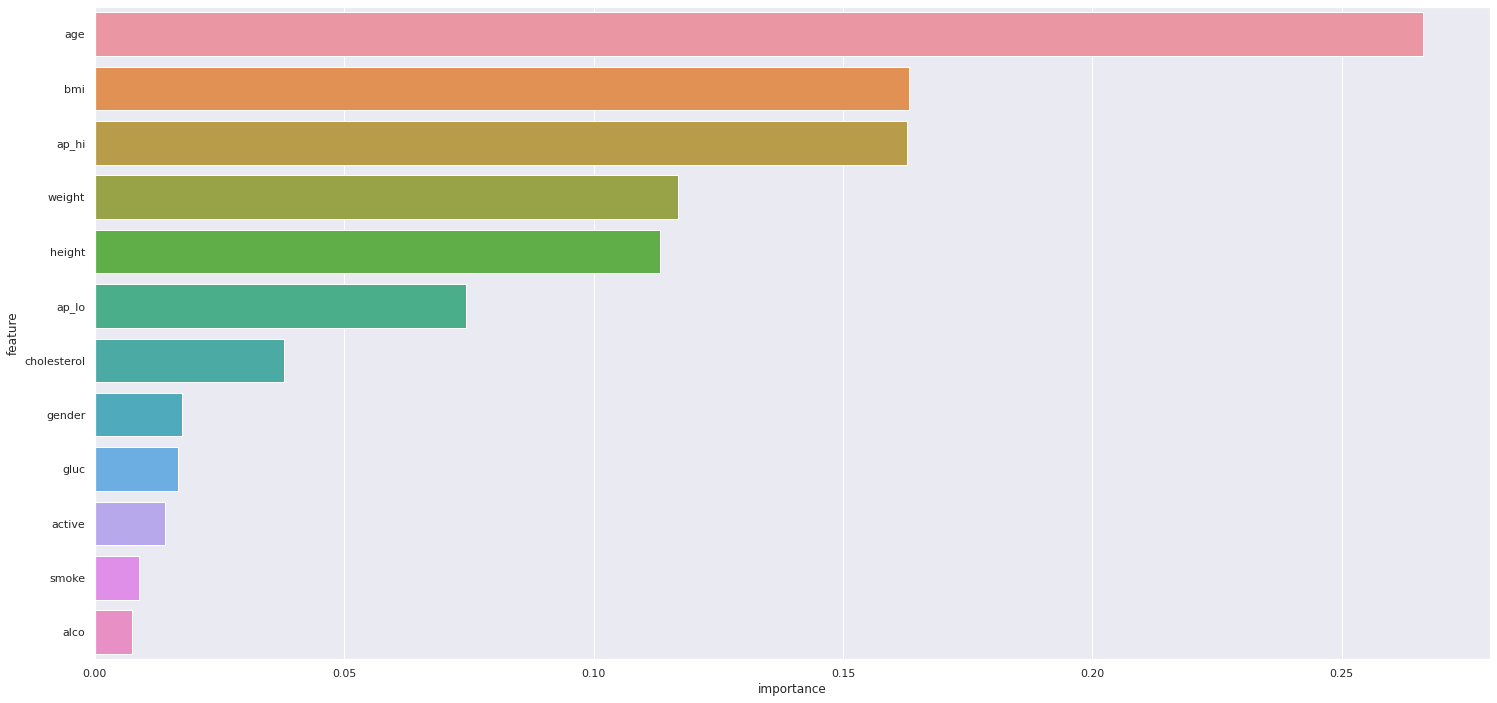

In [67]:
#define RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

rf.fit(x_train, y_train)

importance = pd.DataFrame(zip(x_train.columns, rf.feature_importances_), columns=['feature', 'importance'])

importance = importance.sort_values(by='importance', ascending=False)

sns.barplot(x='importance', y='feature', data=importance)

## Boruta as feature selector

In [68]:
#training and test dataset for Boruta
x_train_n = x_train.values
y_train_n = y_train.values.ravel()


#define Boruta
boruta = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=42).fit(x_train_n,y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	2
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	2
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	2
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	2
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	9
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	9
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	9
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	9
Iteration: 	16 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	9


BorutaPy

In [69]:
 cols_selected = boruta.support_.tolist()
    
#best feature
x_train_fs = x_train
cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()
print('Columns selected: ',cols_selected_boruta)

#not selected from Boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))
print('Columns not selected: ', cols_not_selected_boruta)

Columns selected:  ['age', 'ap_hi', 'bmi']
Columns not selected:  ['active', 'alco', 'ap_lo', 'cholesterol', 'gender', 'gluc', 'height', 'smoke', 'weight']


In [70]:
cols_selected = cols_selected_boruta
#cols_selected = ['weight', 'height', 'ap_hi', 'ap_lo', 'cholesterol']

# Machine learning modeling

In [71]:
x_train = x_train[cols_selected]
x_test = x_test[cols_selected]

Baseline: mínimo 45% de acurácia -> para ser bom, pelo menos 55%
"Acurácia burra" = 48%

## Logistic regression

                 model  accuracy precision_1 recall_1 f1_score_1 precision_0  recall_0 f1_score_0
0  logistic regression  0.706717    0.754914  0.60887   0.674072    0.674353  0.803824   0.733418


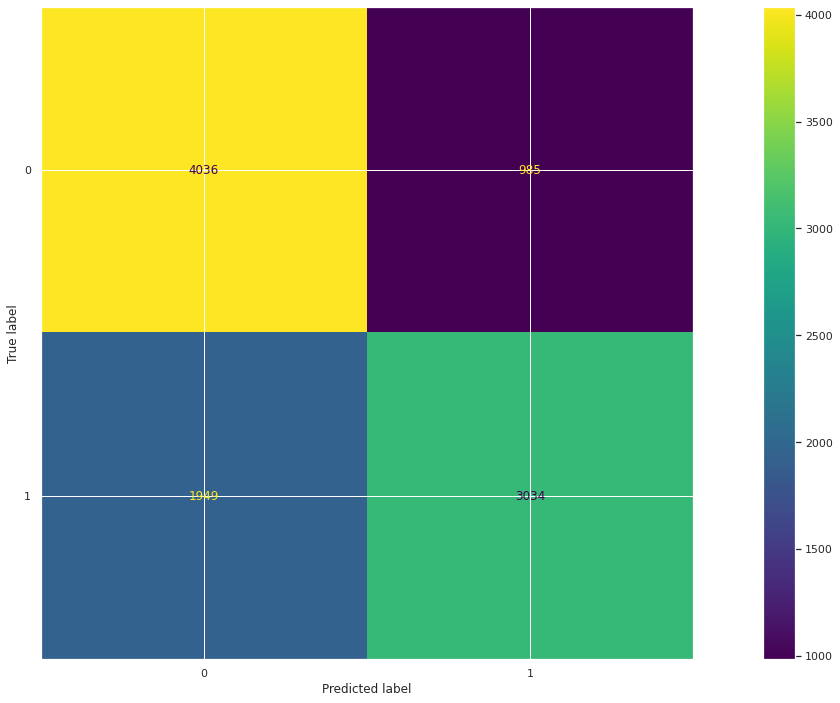

In [73]:
lr = LogisticRegressionCV(random_state=42, max_iter=1000)

lr.fit(x_train, y_train)

yhat_lr = lr.predict(x_test)


performance_lr = metrics(y_test, yhat_lr, 'logistic regression')




In [168]:
# cross validation - default kfold = 5
performance_lr_cv = cross_validation(lr, 'logistic regression', X, y)
performance_lr_cv

,model,accuracy,precision_1,recall_1,f1_score_1
0,logistic regression,0.7219 +/- 0.0052,0.7503 +/- 0.0061,0.6545 +/- 0.008,0.6991 +/- 0.0062


## Random Forest

           model  accuracy precision_1  recall_1 f1_score_1 precision_0  recall_0 f1_score_0
0  random forest  0.665334    0.670704  0.644592   0.657388    0.660403  0.685919   0.672919


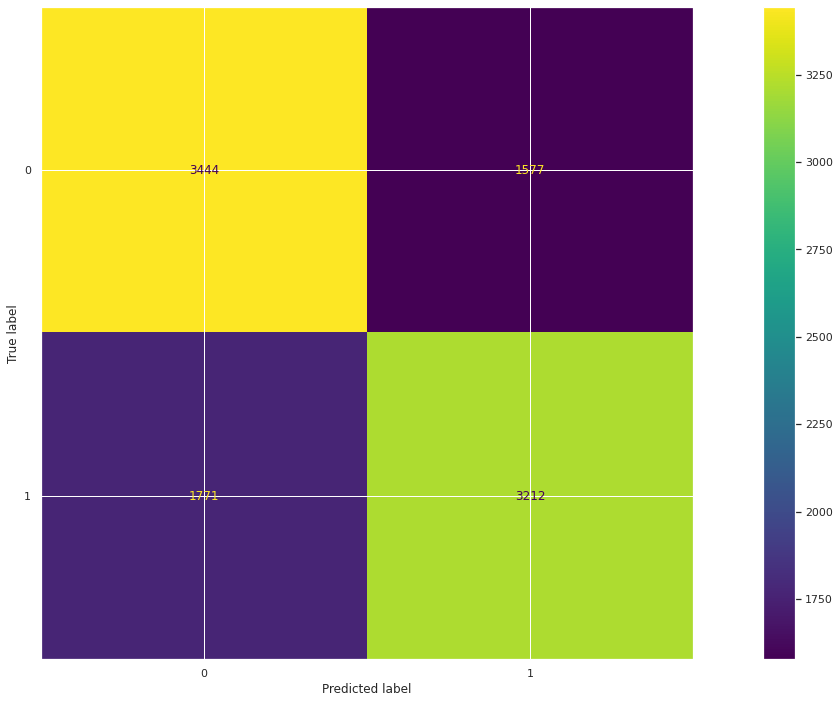

In [74]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(x_train, y_train)

yhat_rf = rf.predict(x_test)

performance_rf = metrics(y_test, yhat_rf, 'random forest')

In [169]:
performance_rf_cv = cross_validation(rf, 'random forest', X, y)
performance_rf_cv

,model,accuracy,precision_1,recall_1,f1_score_1
0,random forest,0.7082 +/- 0.0036,0.7105 +/- 0.0047,0.6902 +/- 0.0085,0.7002 +/- 0.0045


## Gradient Boosting

               model  accuracy precision_1  recall_1 f1_score_1 precision_0  recall_0 f1_score_0
0  gradient boosting  0.717013    0.740716  0.664459   0.700518    0.697868  0.769169   0.731786


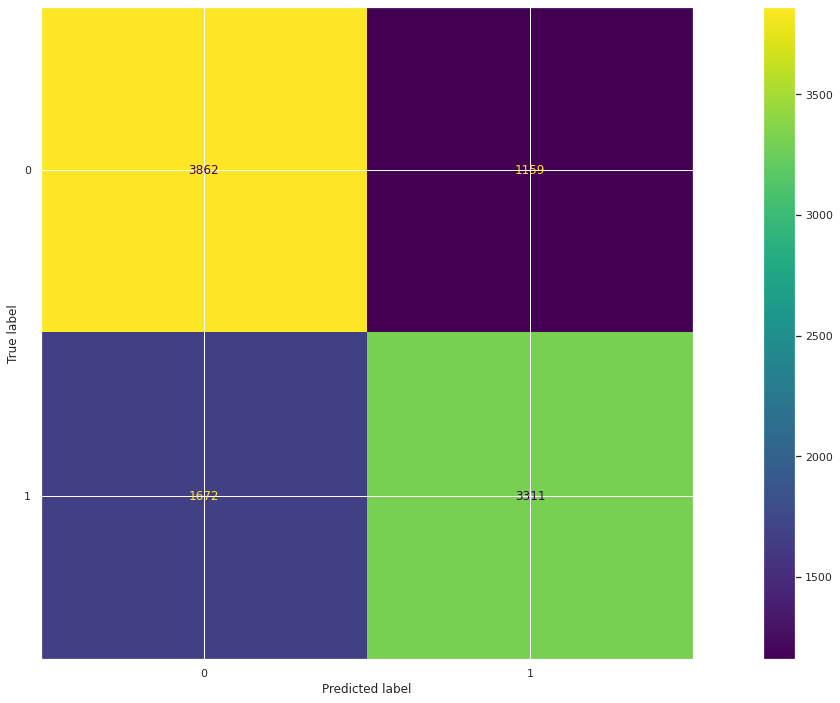

In [75]:
gb = GradientBoostingClassifier(random_state=42)

gb.fit(x_train, y_train)

yhat_gb = gb.predict(x_test)

performance_gb = metrics(y_test, yhat_gb, 'gradient boosting')

In [170]:
# cross validation - default kfold = 5
performance_gb_cv = cross_validation(gb, 'gradient boosting', X, y)
performance_gb_cv

,model,accuracy,precision_1,recall_1,f1_score_1
0,gradient boosting,0.7278 +/- 0.004,0.7433 +/- 0.0056,0.6854 +/- 0.0057,0.7132 +/- 0.0041


## KNN Classifier

  model  accuracy precision_1  recall_1 f1_score_1 precision_0  recall_0 f1_score_0
0   knn  0.680028    0.690303  0.648605   0.668805    0.670988  0.711213   0.690515


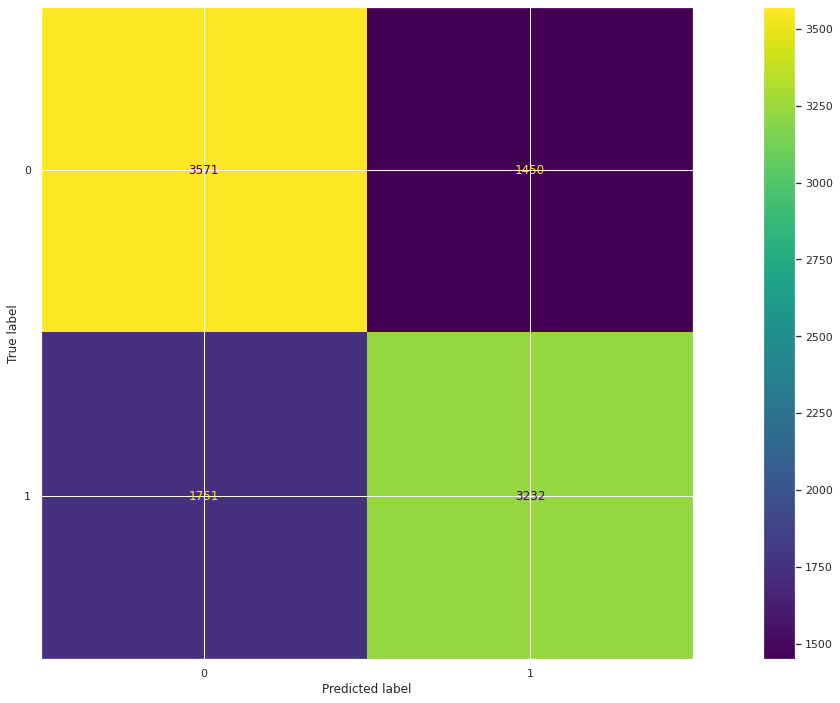

In [76]:
knn = KNeighborsClassifier()

knn.fit(x_train.values, y_train)

yhat_knn = knn.predict(x_test.values)

performance_knn = metrics(y_test, yhat_knn, 'knn')

In [171]:
# cross validation - default kfold = 5
performance_knn_cv = cross_validation(knn, 'knn', X, y)
performance_knn_cv

/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/pa01/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/pa01/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/pa01/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/pa01/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/lrayssa/Documents/data_science/pa01/ca

,model,accuracy,precision_1,recall_1,f1_score_1
0,knn,0.6895 +/- 0.0021,0.6895 +/- 0.002,0.6754 +/- 0.0083,0.6823 +/- 0.0039


## SVM- SVC

     model  accuracy precision_1  recall_1 f1_score_1 precision_0  recall_0 f1_score_0
0  svm-svc  0.716114    0.745813  0.652418   0.695997     0.69318  0.779327   0.733733


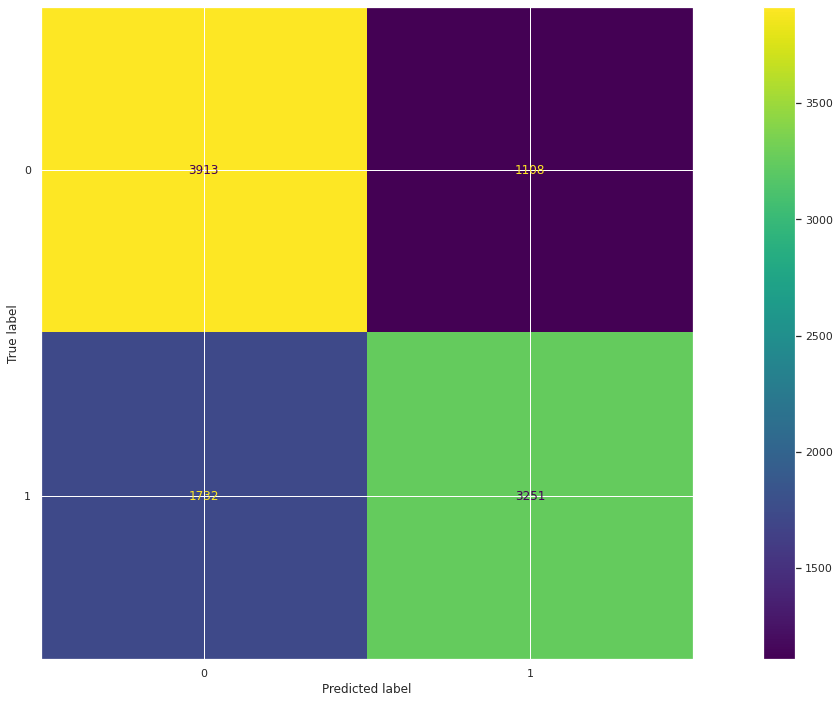

In [77]:
svc = SVC()

svc.fit(x_train, y_train)

yhat_svc = svc.predict(x_test)

performance_svc = metrics(y_test, yhat_svc, 'svm-svc')

In [172]:
# cross validation - default kfold = 5
performance_svc_cv = cross_validation(svc, 'svm-svc', X, y)
performance_svc_cv

,model,accuracy,precision_1,recall_1,f1_score_1
0,svm-svc,0.7255 +/- 0.0031,0.7634 +/- 0.0044,0.6437 +/- 0.0067,0.6984 +/- 0.0042


## XGBoost

[10:43:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
     model  accuracy precision_1  recall_1 f1_score_1 precision_0  recall_0 f1_score_0
0  xgboost  0.702119    0.715423  0.667469   0.690615     0.69057  0.736507   0.712799


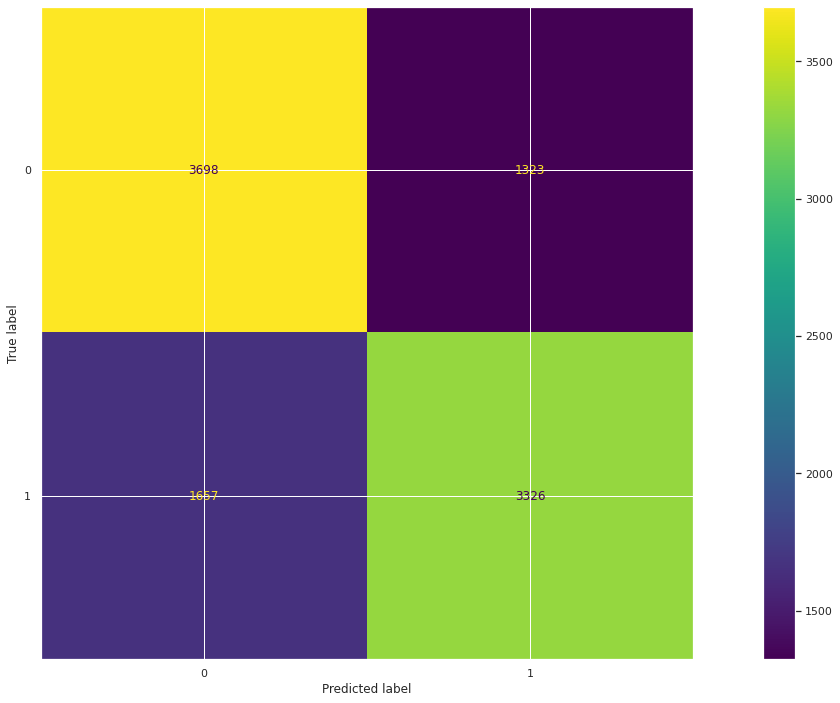

In [80]:
xgbc = xgb.XGBClassifier(use_label_encoder = False)

xgbc.fit(x_train, y_train)

yhat_xgbc = xgbc.predict(x_test)

performance_xgbc = metrics(y_test, yhat_xgbc, 'xgboost')

In [173]:
# cross validation - default kfold = 5
performance_xgbc_cv = cross_validation(xgbc, 'xgboost', X, y)
performance_xgbc_cv

[12:13:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:13:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,model,accuracy,precision_1,recall_1,f1_score_1
0,xgboost,0.7252 +/- 0.001,0.7442 +/- 0.0035,0.6757 +/- 0.0059,0.7083 +/- 0.002


## Comparing performances

In [81]:
performance_overall = pd.concat([performance_lr, performance_rf, performance_gb, performance_knn, performance_svc, performance_xgbc]).reset_index(drop=True)

In [82]:
performance_overall.sort_values(by='accuracy', ascending=False)

,model,accuracy,precision_1,recall_1,f1_score_1,precision_0,recall_0,f1_score_0
2,gradient boosting,0.717013,0.740716,0.664459,0.700518,0.697868,0.769169,0.731786
4,svm-svc,0.716114,0.745813,0.652418,0.695997,0.69318,0.779327,0.733733
0,logistic regression,0.706717,0.754914,0.60887,0.674072,0.674353,0.803824,0.733418
5,xgboost,0.702119,0.715423,0.667469,0.690615,0.69057,0.736507,0.712799
3,knn,0.680028,0.690303,0.648605,0.668805,0.670988,0.711213,0.690515
1,random forest,0.665334,0.670704,0.644592,0.657388,0.660403,0.685919,0.672919


To choose a model, we have to consider the baseline of 45% to 55% of accuracy that already exists. All models performs way better in terms off accuracy. But, since we're talking about health, a false negative could bring serious damage to the patient (because he/she will not start the treatment in early stages) and to the company aswell (lawsuits, reputation). So, we have to find a good balance of performance considering accuracy (money) and recall.  <br>


# K-Fold Cross Validation

In [174]:
performance_overall_cv = pd.concat([performance_lr_cv, performance_rf_cv, performance_gb_cv, performance_knn_cv, performance_svc_cv, performance_xgbc_cv]).reset_index(drop=True)
performance_overall_cv.sort_values(by='accuracy', ascending=False)

,model,accuracy,precision_1,recall_1,f1_score_1
2,gradient boosting,0.7278 +/- 0.004,0.7433 +/- 0.0056,0.6854 +/- 0.0057,0.7132 +/- 0.0041
4,svm-svc,0.7255 +/- 0.0031,0.7634 +/- 0.0044,0.6437 +/- 0.0067,0.6984 +/- 0.0042
5,xgboost,0.7252 +/- 0.001,0.7442 +/- 0.0035,0.6757 +/- 0.0059,0.7083 +/- 0.002
0,logistic regression,0.7219 +/- 0.0052,0.7503 +/- 0.0061,0.6545 +/- 0.008,0.6991 +/- 0.0062
1,random forest,0.7082 +/- 0.0036,0.7105 +/- 0.0047,0.6902 +/- 0.0085,0.7002 +/- 0.0045
3,knn,0.6895 +/- 0.0021,0.6895 +/- 0.002,0.6754 +/- 0.0083,0.6823 +/- 0.0039


The model chosen is the gradient boosting because it represents a good balance in accuracy and recall

# Hyperparameter tuning

## Random Search

In [194]:
param = {
    'learning_rate': [0.1, 0,2, 0.5, 1.0],
    'n_estimators': [100, 150, 170, 250, 300, 350, 500],
    'max_depth': [3, 5, 7],
    'min_weight_fraction_leaf': [0,0.25]
  
    
}

MAX_EVAL = 20

In [195]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    model_gb = GradientBoostingClassifier(learning_rate=hp['learning_rate'],
                                          n_estimators=hp['n_estimators'],
                                          max_depth=hp['max_depth'],
                                          min_weight_fraction_leaf=hp['min_weight_fraction_leaf'],                                          
                                          random_state=42)
    result = cross_validation(model_gb, 'gradient boosting', X, y)
    result = pd.concat([result, pd.DataFrame(hp, index=[0])], axis=1)
    
    final_result = pd.concat( [final_result, result] )
       
final_result
    

{'learning_rate': 0.1, 'n_estimators': 150, 'max_depth': 3, 'min_weight_fraction_leaf': 0}
{'learning_rate': 1.0, 'n_estimators': 500, 'max_depth': 7, 'min_weight_fraction_leaf': 0}
{'learning_rate': 1.0, 'n_estimators': 350, 'max_depth': 5, 'min_weight_fraction_leaf': 0}
{'learning_rate': 0.1, 'n_estimators': 250, 'max_depth': 5, 'min_weight_fraction_leaf': 0}
{'learning_rate': 0.5, 'n_estimators': 150, 'max_depth': 5, 'min_weight_fraction_leaf': 0}
{'learning_rate': 0.5, 'n_estimators': 300, 'max_depth': 3, 'min_weight_fraction_leaf': 0}
{'learning_rate': 2, 'n_estimators': 100, 'max_depth': 3, 'min_weight_fraction_leaf': 0.25}
{'learning_rate': 0, 'n_estimators': 150, 'max_depth': 7, 'min_weight_fraction_leaf': 0.25}
{'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_weight_fraction_leaf': 0}


/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/pa01/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/pa01/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/pa01/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 525, in fit
    self._check_params()
  File "/home/lrayssa/Documents/dat

{'learning_rate': 0.1, 'n_estimators': 150, 'max_depth': 7, 'min_weight_fraction_leaf': 0}
{'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_weight_fraction_leaf': 0.25}
{'learning_rate': 2, 'n_estimators': 500, 'max_depth': 3, 'min_weight_fraction_leaf': 0}
{'learning_rate': 0, 'n_estimators': 350, 'max_depth': 3, 'min_weight_fraction_leaf': 0.25}
{'learning_rate': 1.0, 'n_estimators': 250, 'max_depth': 7, 'min_weight_fraction_leaf': 0.25}


/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/pa01/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/pa01/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/pa01/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 525, in fit
    self._check_params()
  File "/home/lrayssa/Documents/dat

{'learning_rate': 0, 'n_estimators': 500, 'max_depth': 3, 'min_weight_fraction_leaf': 0.25}
{'learning_rate': 0.5, 'n_estimators': 170, 'max_depth': 5, 'min_weight_fraction_leaf': 0.25}


/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/pa01/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/pa01/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/pa01/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 525, in fit
    self._check_params()
  File "/home/lrayssa/Documents/dat

{'learning_rate': 1.0, 'n_estimators': 500, 'max_depth': 3, 'min_weight_fraction_leaf': 0.25}
{'learning_rate': 0, 'n_estimators': 150, 'max_depth': 7, 'min_weight_fraction_leaf': 0.25}
{'learning_rate': 0, 'n_estimators': 170, 'max_depth': 3, 'min_weight_fraction_leaf': 0}
{'learning_rate': 1.0, 'n_estimators': 250, 'max_depth': 3, 'min_weight_fraction_leaf': 0}


/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/pa01/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/pa01/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/pa01/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 525, in fit
    self._check_params()
  File "/home/lrayssa/Documents/dat

,model,accuracy,precision_1,recall_1,f1_score_1,learning_rate,n_estimators,max_depth,min_weight_fraction_leaf
0,gradient boosting,0.7281 +/- 0.004,0.7438 +/- 0.0055,0.6854 +/- 0.0048,0.7134 +/- 0.0039,0.1,150,3,0.00
0,gradient boosting,0.6641 +/- 0.003,0.6629 +/- 0.0043,0.6504 +/- 0.0033,0.6566 +/- 0.0022,1.0,500,7,0.00
0,gradient boosting,0.6702 +/- 0.0028,0.6706 +/- 0.0041,0.6527 +/- 0.0062,0.6615 +/- 0.0032,1.0,350,5,0.00
0,gradient boosting,0.7269 +/- 0.0019,0.7456 +/- 0.0046,0.6784 +/- 0.0055,0.7104 +/- 0.002,0.1,250,5,0.00
0,gradient boosting,0.7118 +/- 0.0021,0.7259 +/- 0.0035,0.6688 +/- 0.0051,0.6961 +/- 0.0025,0.5,150,5,0.00
0,gradient boosting,0.7191 +/- 0.0043,0.7343 +/- 0.0068,0.6756 +/- 0.0056,0.7037 +/- 0.004,0.5,300,3,0.00
0,gradient boosting,0.5114 +/- 0.0353,0.5404 +/- 0.0934,0.8491 +/- 0.3018,0.6023 +/- 0.1175,2.0,100,3,0.25
0,gradient boosting,nan +/- nan,nan +/- nan,nan +/- nan,nan +/- nan,0.0,150,7,0.25
0,gradient boosting,0.7241 +/- 0.0024,0.7419 +/- 0.0045,0.6767 +/- 0.0038,0.7078 +/- 0.0021,0.1,500,5,0.00
0,gradient boosting,0.7234 +/- 0.0028,0.7419 +/- 0.0054,0.6744 +/- 0.0066,0.7065 +/- 0.0031,0.1,150,7,0.00


In [196]:
final_result.sort_values(by='accuracy', ascending=False)

,model,accuracy,precision_1,recall_1,f1_score_1,learning_rate,n_estimators,max_depth,min_weight_fraction_leaf
0,gradient boosting,nan +/- nan,nan +/- nan,nan +/- nan,nan +/- nan,0.0,170,3,0.00
0,gradient boosting,nan +/- nan,nan +/- nan,nan +/- nan,nan +/- nan,0.0,150,7,0.25
0,gradient boosting,nan +/- nan,nan +/- nan,nan +/- nan,nan +/- nan,0.0,150,7,0.25
0,gradient boosting,nan +/- nan,nan +/- nan,nan +/- nan,nan +/- nan,0.0,500,3,0.25
0,gradient boosting,nan +/- nan,nan +/- nan,nan +/- nan,nan +/- nan,0.0,350,3,0.25
0,gradient boosting,0.7281 +/- 0.004,0.7438 +/- 0.0055,0.6854 +/- 0.0048,0.7134 +/- 0.0039,0.1,150,3,0.00
0,gradient boosting,0.7269 +/- 0.0019,0.7456 +/- 0.0046,0.6784 +/- 0.0055,0.7104 +/- 0.002,0.1,250,5,0.00
0,gradient boosting,0.7241 +/- 0.0024,0.7419 +/- 0.0045,0.6767 +/- 0.0038,0.7078 +/- 0.0021,0.1,500,5,0.00
0,gradient boosting,0.7234 +/- 0.0028,0.7419 +/- 0.0054,0.6744 +/- 0.0066,0.7065 +/- 0.0031,0.1,150,7,0.00
0,gradient boosting,0.7191 +/- 0.0043,0.7343 +/- 0.0068,0.6756 +/- 0.0056,0.7037 +/- 0.004,0.5,300,3,0.00


In [197]:
# best parameeters: {'learning_rate': 0.1, 'n_estimators': 150, 'max_depth': 3, 'min_weight_fraction_leaf': 0}

# Final model

                      model  accuracy precision_1  recall_1 f1_score_1 precision_0  recall_0 f1_score_0
0  gradiend boosting tunned  0.730481     0.74277  0.693041   0.717045    0.720022  0.766851   0.742699


,model,accuracy,precision_1,recall_1,f1_score_1,precision_0,recall_0,f1_score_0
0,gradiend boosting tunned,0.730481,0.74277,0.693041,0.717045,0.720022,0.766851,0.742699


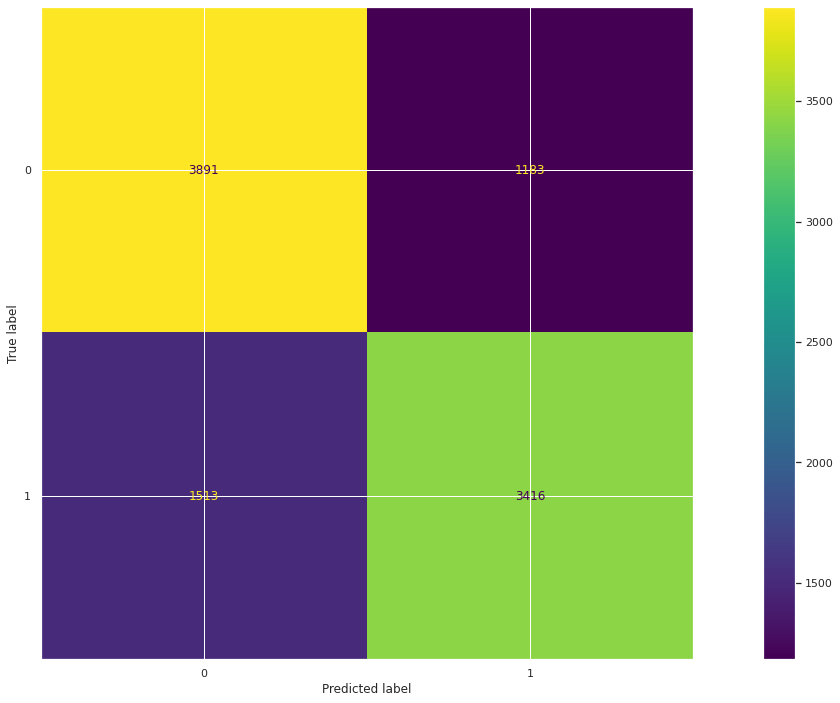

In [202]:
param_tuned = {
    'learning_rate': 0.1,
    'n_estimators': 150,
    'max_depth': 3,
    'min_weight_fraction_leaf': 0
  
    
}

model_gb_tunned = GradientBoostingClassifier(learning_rate=param_tuned['learning_rate'],
                                          n_estimators=param_tuned['n_estimators'],
                                          max_depth=param_tuned['max_depth'],
                                          min_weight_fraction_leaf=param_tuned['min_weight_fraction_leaf'],                                          
                                          random_state=42).fit(x_train, y_train)

yhat_gb_tunned = model_gb_tunned.predict(x_test)

final_performance = metrics(y_test, yhat_gb_tunned, 'gradiend boosting tunned')
final_performance



# Peformance

## Business performance

In [203]:
# calculates the cross validation scores
performance_cv = cross_validation(model_gb_tunned, 'gradient boosting tunned', X, y)
performance_cv

,model,accuracy,precision_1,recall_1,f1_score_1
0,gradient boosting tunned,0.7281 +/- 0.004,0.7438 +/- 0.0055,0.6854 +/- 0.0048,0.7134 +/- 0.0039


In [204]:
price_per_percent = 500/5
baseline = 50
num_pacients = 70000

model_accuracy = 0.7281
deviation = 0.004

accuracy_lower = (model_accuracy - deviation) * 100
accuracy_upper = (model_accuracy + deviation) * 100

percent_difference_lower = accuracy_lower - baseline
percent_difference_upper = accuracy_upper - baseline

amount_best = percent_difference_upper * price_per_percent * num_pacients
amount_worst = percent_difference_lower * price_per_percent * num_pacients

In [208]:
print(f'Best:  ${round(amount_best, 2):,.2f}')
print(f'Worst: ${round(amount_worst, 2):,.2f}')

Best:  $162,470,000.00
Worst: $156,870,000.00


Next steps: define how can we increase the accuracy of the model? <br>

-- Include more features <br>
-- Try different ways to do the hyperparameter finetuning <br>
-- Brainstorm over the data about the quality of the information <br>